In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr
import logomaker
from umap import UMAP
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

from matplotlib import font_manager

font_path = '/Users/tsztain/Downloads/Helvetica.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)


import matplotlib.pylab as pylab
params = {'font.family': 'sans-serif',
          'font.sans-serif': prop.get_name(),
         'legend.fontsize': '24',
         'figure.figsize': (12,12),
         'axes.labelsize': '24',
         'axes.titlesize': '24',
         'xtick.labelsize': '24',
         'ytick.labelsize': '24'}
pylab.rcParams.update(params)



# Data Processing

In [ ]:
amino_acidsl = list("ACDEFGHIKLMNPQRSTVWY")
wt_seq = "NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST"

def get_mutant_seq(wt_seq, mutations):
    mutant_seq = wt_seq
    for mutation in mutations:
        mutant_seq = mutant_seq[:int(mutation[1:-1])-1] + mutation[-1] + mutant_seq[int(mutation[1:-1]):]
    return mutant_seq

In [ ]:
df = pd.read_csv("raw/binding_Kds.csv")
df_filtered = df[df['delta_log10Ka'].notna()] # remove samples that don't have Ka values
df_unique = df_filtered.groupby(['library', 'aa_substitutions'])['delta_log10Ka'].mean() # mean of duplicates inside libraries
df_unique = df_unique.reset_index().groupby('aa_substitutions')['delta_log10Ka'].mean() # mean of duplicates across libraries

values = []
for i in range(df_unique.shape[0]):
    values.append(str(i)+','+get_mutant_seq(wt_seq, df_unique.index[i].split(' '))+','+str(df_unique.iloc[i]))

# split into train, test, valid
random.shuffle(values)

train_data = values[:int((len(values)+1).80)] # 80% training  
test_data = values[int((len(values)+1).90):] # 10% test  
valid_data = values[int((len(values)+1).80):int((len(values)+1).90)] # 10% valid

textfile = open("train_data.csv", "w") for element in train_data: textfile.write(element + "\n") textfile.close()
textfile = open("test_data.csv", "w") for element in test_data: textfile.write(element + "\n") textfile.close()
textfile = open("valid_data.csv", "w") for element in valid_data: textfile.write(element + "\n") textfile.close()

# Create fasta
path="~/raw"
dataframe={dataset: pd.read_csv("{}/{}_data.csv".format(path,dataset), header=None)
           for dataset in ["train", "test", "valid"]}

#Write sequences in fasta format
#subprocess.run("mkdir {}/fastaseq".format(path),shell=True)
for dataset in dataframe.keys():
    with open("~/fastaseq/{}.fasta".format(dataset),"w") as f:
        for i,s in enumerate(dataframe[dataset][1]):
            f.write(">{}\n{}\n".format(i,s))

# Model architecture performance on base dataset

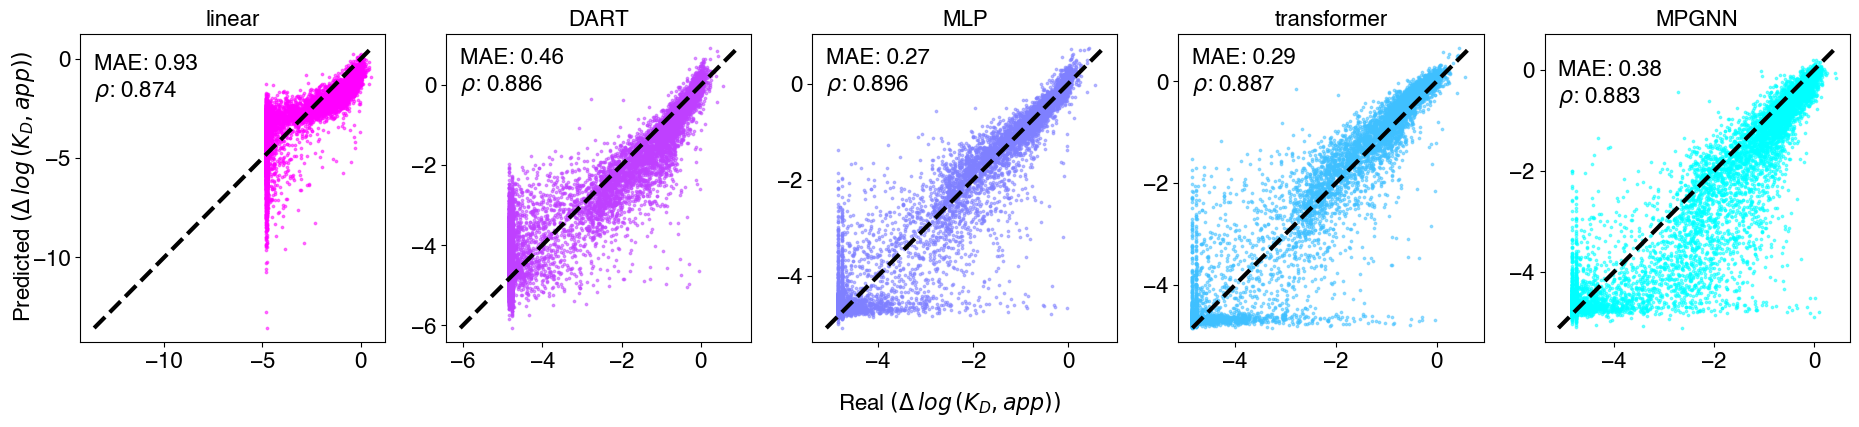

In [13]:
directory = '/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/base_data/'
datasets = ["TESTEVAL_linear_wdecay0.0005_learningrate0.0001_baseonly_nulltuner_multiattempt.csv", "tree_predictions.csv", "TESTEVAL_mlp_l[16, 32, 16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt.csv", "TESTEVAL_b6_h8_e64_wdecay0.005_mlpdrop0.1_mhadrop0.05_flayers1_fdrop0.1_baseonly_multiattempt.csv", "mpn_basedata_nulltuner_val_table.csv"] #, ""]
labels = ["linear", "DART", "MLP", "transformer", "MPGNN"]

set2data = {}
for i,data in enumerate(datasets):
    df = pd.read_csv(directory+data, index_col=0)
    experiments = list((set(df["experiment"])))

    df_base = df[df["experiment"] == "base"]
    x = df_base["reference"] 
    y = df_base["raw"]

    set2data[labels[i]] = np.column_stack((x, y))  

# Plot predictions
fig = plt.figure(figsize=(37,4))

cmap = plt.get_cmap('cool_r')
n = 5
colors = [cmap(i / (n - 1)) for i in range(n)]

for i, label in enumerate(labels):
    x = set2data[label][:, 0]
    y = set2data[label][:, 1]

    # get statistics
    MAE = mean_absolute_error(x,y)
    MSE = mean_squared_error(x,y)
    sp = spearmanr(x,y)[0]

    # get center line
    y1 = [min(min(x),min(y)),max(max(x),max(y))]
    x1 = y1 

    ax = fig.add_subplot(1,8,i+1)

    ax.scatter(x, y, s=3, color=colors[i], alpha=.5)
    ax.plot(x1,y1,linewidth=3, color="black", linestyle="dashed")
    ax.text(min(y),max(y),'MAE: {:1.2f} \n' r"$\rho$:" ' {:1.3f}'.format(MAE, sp), fontsize=16, va='top')
    ax.set_title(labels[i], fontsize=16)

    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)

fig.text(.106,.5,'Predicted ' r"$(\Delta\/ log\/(K_D,app))$", va='center', rotation='vertical', fontsize=16)
fig.text(.36,-0.06,'Real ' r"$(\Delta\/ log\/(K_D,app))$", ha='center', fontsize=16)
fig.savefig('{}raw_regression_accuracy.png'.format(directory), bbox_inches='tight')
plt.show()

# new datasets train and test independently 

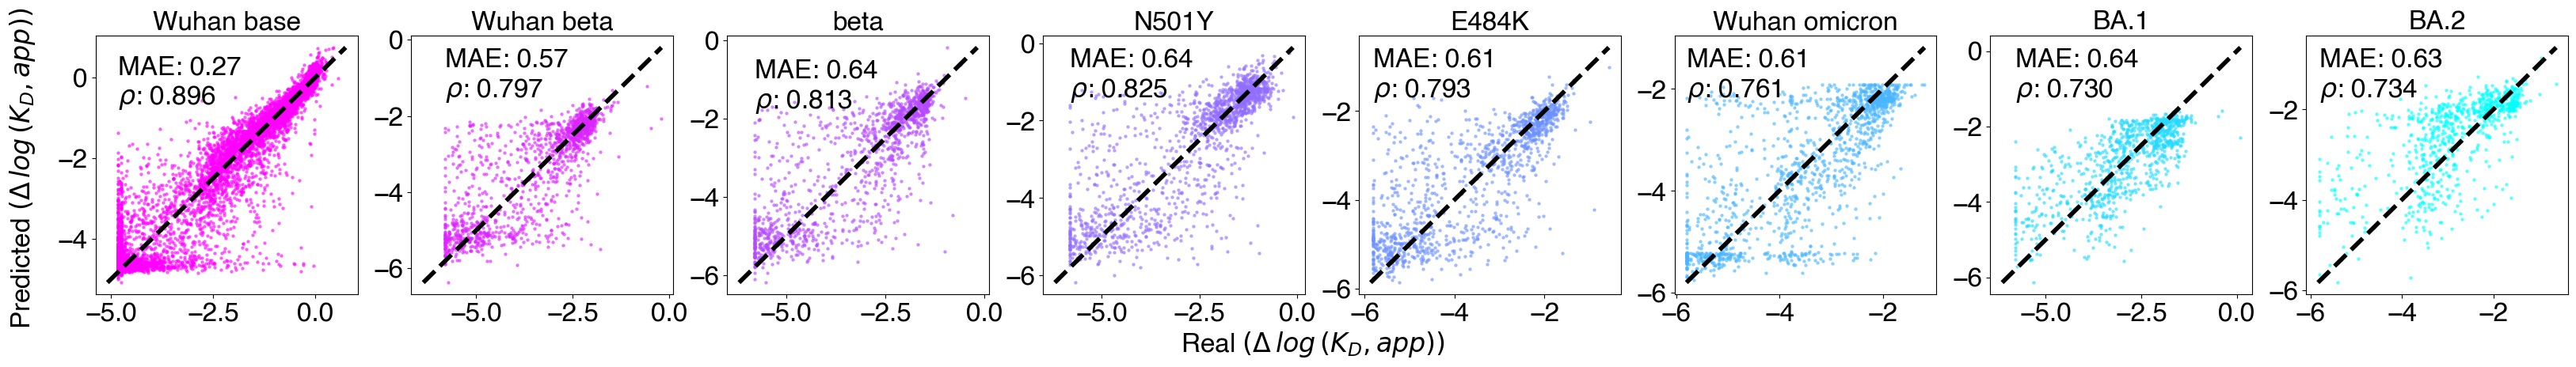

In [40]:
directory = '/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/base_data/'
datasets = ['TESTEVAL_mlp_l[16, 32, 16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt.csv',
           'TESTEVAL_mlp_l[16, 64]_wdecay0.005_learningrate0.0003_wuhanonly_nulltuner_multiattempt.csv',
           'TESTEVAL_mlp_l[16, 64]_wdecay0.0005_learningrate0.0003_B1351only_nulltuner_multiattempt.csv',
           'TESTEVAL_mlp_l[8, 8, 8]_wdecay0.001_learningrate0.0003_N501Yonly_nulltuner_multiattempt.csv',
           'TESTEVAL_mlp_l[8, 32, 64]_wdecay0.0001_learningrate0.0003_E484Konly_nulltuner_multiattempt.csv',
           'TESTEVAL_mlp_l[8, 8, 16]_wdecay0.005_learningrate0.0003_wuhanomicrononly_nulltuner_multiattempt.csv',
           'TESTEVAL_mlp_l[32, 8, 8]_wdecay0.0005_learningrate0.0001_ba1only_nulltuner_multiattempt.csv',
           'TESTEVAL_mlp_l[256, 256, 256]_wdecay0.001_learningrate0.0001_ba2only_nulltuner_multiattempt.csv']

keys = ["base", "wuhan", "B1351", "N501Y", "E484K", "wuhan_omicron", "BA1", "BA2"]
labels = ["Wuhan base", "Wuhan beta", "beta", "N501Y", "E484K", "Wuhan omicron", "BA.1", "BA.2"]

fig = plt.figure(figsize=(32,4.3))

for i,data in enumerate(datasets):
    df = pd.read_csv(directory+data, index_col=0)

    exp2data = {}

    df_exp = df[df["experiment"] == keys[i]]
    x = df_exp["reference"]
    y = df_exp["tuned"]

    exp2data[keys[i]] = np.column_stack((x, y))  # shape (N, 2)

    # Plot predictions

    cmap = plt.get_cmap('cool_r')
    n = 8
    colors = [cmap(i / (n - 1)) for i in range(n)]

    # get statistics
    MAE = mean_absolute_error(x,y)
    MSE = mean_squared_error(x,y)
    sp = spearmanr(x,y)[0]

    # get center line
    y1 = [min(min(x),min(y)),max(max(x),max(y))]
    x1 = y1 

    ax = fig.add_subplot(1,8,i+1)

    ax.scatter(x, y, s=5, color=colors[i], alpha=.5)
    ax.plot(x1,y1,linewidth=4, color="black", linestyle="dashed")
    ax.text(min(x),max(x),'MAE: {:1.2f} \n' r"$\rho$:" ' {:1.3f}'.format(MAE, sp), fontsize=24, va='top')
    ax.set_title(labels[i], fontsize=24)

    plt.rc('xtick', labelsize=24)
    plt.rc('ytick', labelsize=24)

fig.text(-.015,.5,'Predicted ' r"$(\Delta\/ log\/(K_D,app))$", va='center', rotation='vertical', fontsize=24)
fig.text(.5,-.04,'Real ' r"$(\Delta\/ log\/(K_D,app))$", ha='center', fontsize=24)
fig.tight_layout()
fig.savefig('{}independent.png'.format(directory), bbox_inches='tight')
plt.show()

# Out of distribution - train only on base 

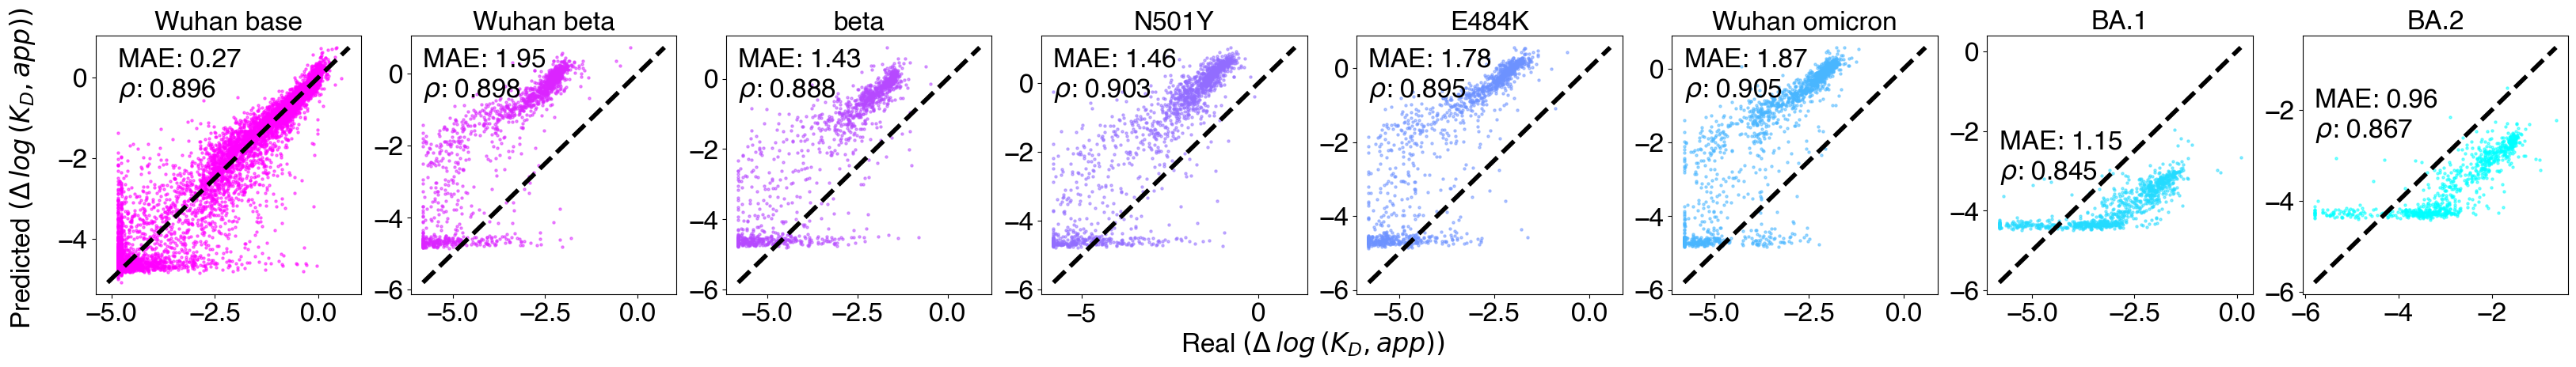

In [43]:
directory = '/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/base_data/'
datasets = ["TESTEVAL_mlp_l[16, 32, 16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt.csv"]

fig = plt.figure(figsize=(32,4.3))

for i,data in enumerate(datasets):
    df = pd.read_csv(directory+data, index_col=0)
    experiments = list((set(df["experiment"])))

    exp2data = {}
    for exp in experiments:
        df_exp = df[df["experiment"] == exp]
        x = df_exp["reference"] 
        y = df_exp["tuned"]

        exp2data[exp] = np.column_stack((x, y))  # shape (N, 2)

    # Plot predictions

    cmap = plt.get_cmap('cool_r')
    n = 8
    colors = [cmap(i / (n - 1)) for i in range(n)]

    keys = ["base", "wuhan", "B1351", "N501Y", "E484K", "wuhan_omicron", "BA1", "BA2"]
    labels = ["Wuhan base", "Wuhan beta", "beta", "N501Y", "E484K", "Wuhan omicron", "BA.1", "BA.2"]

    for j, key in enumerate(keys):
        x = exp2data[key][:, 0]
        y = exp2data[key][:, 1]

        # get statistics
        MAE = mean_absolute_error(x,y)
        MSE = mean_squared_error(x,y)
        sp = spearmanr(x,y)[0]
    
        # get center line
        y1 = [min(min(x),min(y)),max(max(x),max(y))]
        x1 = y1 

        ax = fig.add_subplot(1,8,(8*i)+j+1)
    
        ax.scatter(x, y, s=5, color=colors[j], alpha=.5)
        ax.plot(x1,y1,linewidth=4, color="black", linestyle="dashed")
        ax.text(min(x),max(y),'MAE: {:1.2f} \n' r"$\rho$:" ' {:1.3f}'.format(MAE, sp), fontsize=24, va='top')
        ax.set_title(labels[j], fontsize=24)

        plt.rc('xtick', labelsize=24)
        plt.rc('ytick', labelsize=24)

fig.text(-.015,.5,'Predicted ' r"$(\Delta\/ log\/(K_D,app))$", va='center', rotation='vertical', fontsize=24)
fig.text(.5,-.04,'Real ' r"$(\Delta\/ log\/(K_D,app))$", ha='center', fontsize=24)
fig.tight_layout()
fig.savefig('{}ood.png'.format(directory), bbox_inches='tight')
plt.show()

# Predictions on multiple datasets with and without tuning

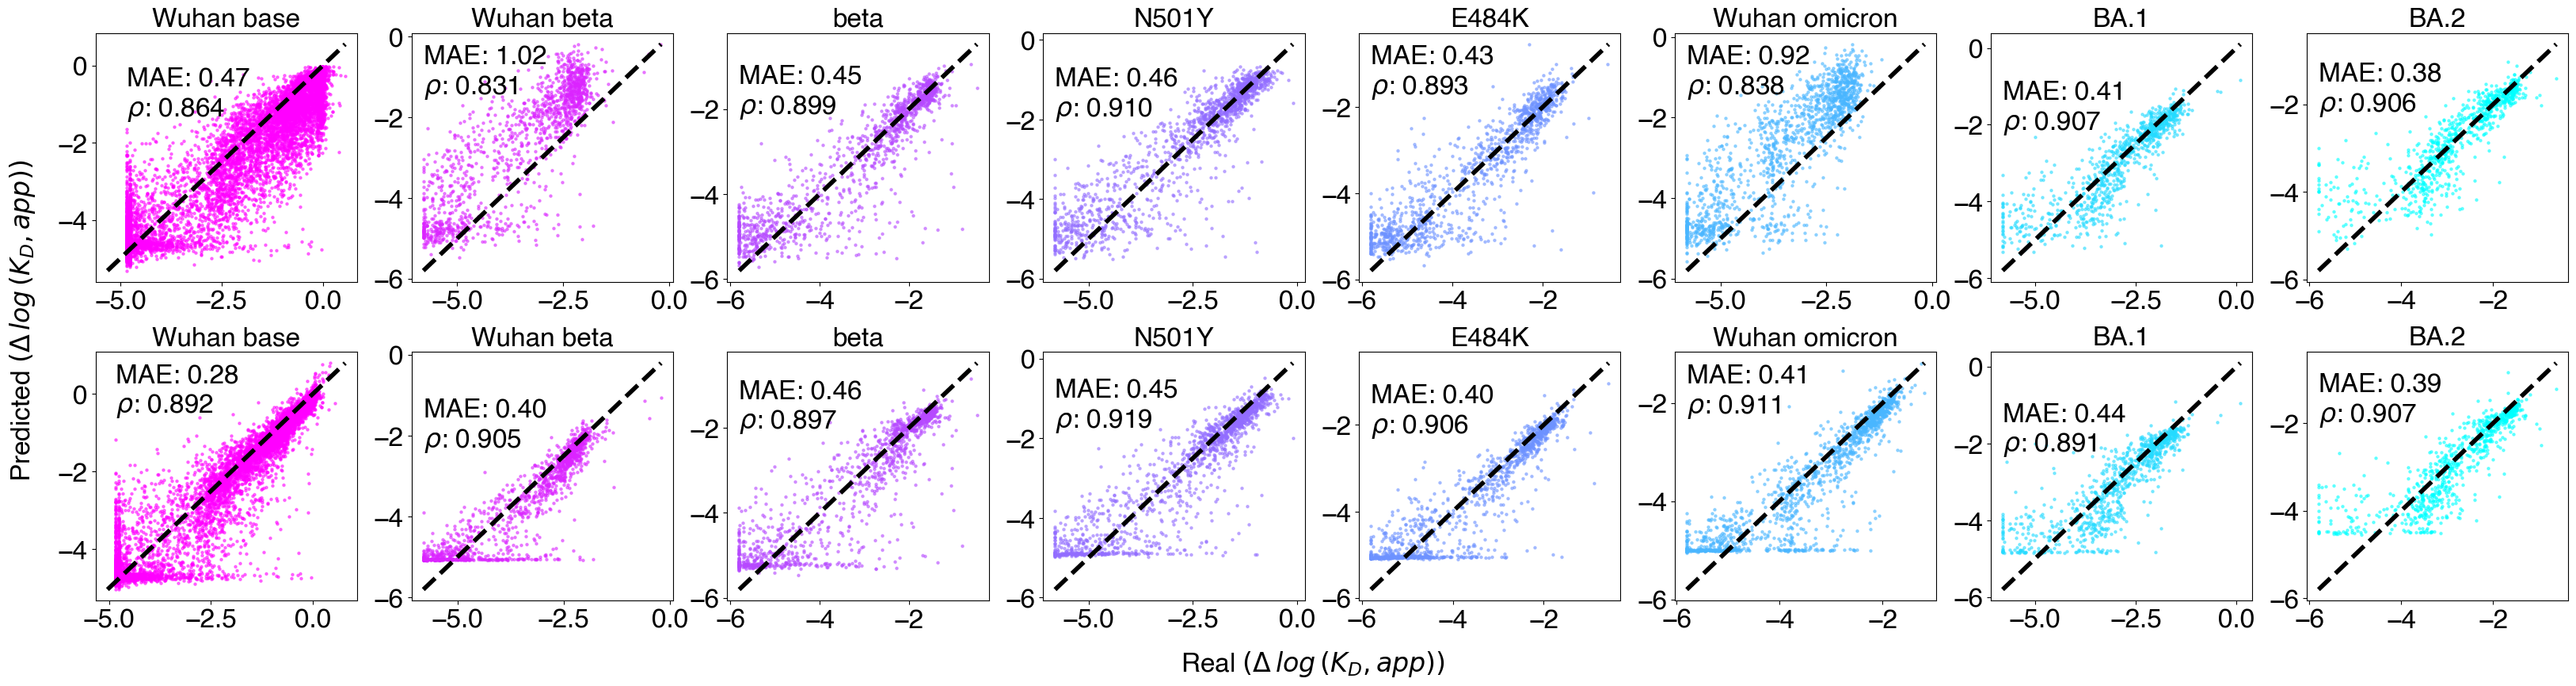

In [16]:
directory = '/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/exp_heads/'
datasets = ["TESTEVAL_mlp_l[8, 256, 32]_wdecay0.0001_learningrate0.0001_alldata_nulltuner_multiattempt.csv", "TESTEVAL_mlp_l[8, 8, 8]_wdecay0.0005_learningrate0.0001_alldata_fan8_multiattempt.csv"]
# first is without tuning, second is with

fig = plt.figure(figsize=(32,8.2))

for i,data in enumerate(datasets):
    df = pd.read_csv(directory+data, index_col=0)
    experiments = list((set(df["experiment"])))

    exp2data = {}
    for exp in experiments:
        df_exp = df[df["experiment"] == exp]
        x = df_exp["reference"] 
        y = df_exp["tuned"]

        exp2data[exp] = np.column_stack((x, y))  # shape (N, 2)

    # Plot predictions

    cmap = plt.get_cmap('cool_r')
    n = 8
    colors = [cmap(i / (n - 1)) for i in range(n)]

    keys = ["base", "wuhan", "B1351", "N501Y", "E484K", "wuhan_omicron", "BA1", "BA2"]
    labels = ["Wuhan base", "Wuhan beta", "beta", "N501Y", "E484K", "Wuhan omicron", "BA.1", "BA.2"]

    for j, key in enumerate(keys):
        x = exp2data[key][:, 0]
        y = exp2data[key][:, 1]

        # get statistics
        MAE = mean_absolute_error(x,y)
        MSE = mean_squared_error(x,y)
        sp = spearmanr(x,y)[0]
    
        # get center line
        y1 = [min(min(x),min(y)),max(max(x),max(y))]
        x1 = y1 

        ax = fig.add_subplot(2,8,(8*i)+j+1)
    
        ax.scatter(x, y, s=5, color=colors[j], alpha=.5)
        ax.plot(x1,y1,linewidth=4, color="black", linestyle="dashed")
        ax.text(min(x),max(y),'MAE: {:1.2f} \n' r"$\rho$:" ' {:1.3f}'.format(MAE, sp), fontsize=24, va='top')
        ax.set_title(labels[j], fontsize=24)

        plt.rc('xtick', labelsize=24)
        plt.rc('ytick', labelsize=24)

fig.text(-.015,.5,'Predicted ' r"$(\Delta\/ log\/(K_D,app))$", va='center', rotation='vertical', fontsize=24)
fig.text(.5,-.04,'Real ' r"$(\Delta\/ log\/(K_D,app))$", ha='center', fontsize=24)
fig.tight_layout()
fig.savefig('{}train_pred_all.png'.format(directory, data, exp), bbox_inches='tight')
plt.show()

# Point mutation effects vs NN

In [270]:
# generate a 201 x 20 matrix with the kd of the point mutants 
directory = '/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS'
df = pd.read_csv("{}/raw/binding_Kds.csv".format(directory))
df_filtered = df[df['n_aa_substitutions'] == 1]
df_notna = df_filtered[df_filtered['delta_log10Ka'].notna()] # remove samples that don't have Ka values
df_unique = df_notna.groupby(['library', 'aa_substitutions'], as_index=False)['delta_log10Ka'].mean() # mean of duplicates inside libraries
df_point = df_unique.reset_index().groupby('aa_substitutions', as_index=False)['delta_log10Ka'].mean() # mean of duplicates across libraries

point_seqs = []
for i in range(df_point.shape[0]):
    point_seqs.append(get_mutant_seq(wt_seq, [df_point['aa_substitutions'].iloc[i]]))

print('# point mutants with KD values: {}'.format(len(point_seqs)))

M_int = np.zeros((201,20))
for ind,seq in enumerate(point_seqs):
    for idx,aa in enumerate(seq):
        if wt_seq[idx] != aa:
            M_int[idx][amino_acidsl.index(aa)] = df_point["delta_log10Ka"].iloc[ind]

# go through the entire dataset and if the point mutations are available for each mutation,
# calculate AE either using the best mlp vs adding vs averaging 

all_df = pd.read_csv('{}/raw/all_data.csv'.format(directory), header=None)
seqs = all_df[1]

mlp_df = pd.read_csv('{}/base_data/TESTEVAL_mlp_l[16,32,16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt_all_pred_table.csv'.format(directory), header=None)

# only eval on the "all" dataset the eval table automatically outputs vals for other datasets
all_mlp_df = mlp_df.iloc[0:105525,:]
label = all_mlp_df.iloc[:,0]
pred = all_mlp_df.iloc[:,2]

linear_df = pd.read_csv('{}/base_data/TESTEVAL_linear_wdecay0.0005_learningrate0.0001_baseonly_nulltuner_multiattempt_train_pred_table.csv'.format(directory), header=None)

# only eval on the "all" dataset the eval table automatically outputs vals for other datasets
all_linear_df = linear_df.iloc[0:105525,:]
linear_pred = all_linear_df.iloc[:,2]

from collections import defaultdict
label_dict = defaultdict(list)
pred_dict = defaultdict(list)
linear_dict = defaultdict(list)
additive_dict = defaultdict(list)
mean_dict = defaultdict(list)

for i, seq in enumerate(seqs):
    muts = []
    mut_kds = []

    # identify all mutations vs wild type
    for idx, aa in enumerate(seq):
        if wt_seq[idx] != aa:
            muts.append([idx, aa])
    
    # this is so we can divide the dictionaries based on how many mutations from wt are present
    num_mut_value = len(muts)

    # collect kd values for all mutations
    for mut in muts:
        kd_val = M_int[mut[0]][amino_acidsl.index(mut[1])]
        mut_kds.append(kd_val)

    # if there is no kd for the point mutation, we cant do the comparisson, so just skip this one. 
    if any(kd_val == 0 for kd_val in mut_kds):
        continue

    label_dict[num_mut_value].append(label[i])
    pred_dict[num_mut_value].append(pred[i])
    linear_dict[num_mut_value].append(linear_pred[i])
    additive_dict[num_mut_value].append(np.sum(mut_kds))
    mean_dict[num_mut_value].append(np.mean(mut_kds))

for i in range(10):
    print('# sequences with {} mutations: {}'.format(i, len(label_dict[i])))

# point mutants with KD values: 3602
# sequences with 0 mutations: 0
# sequences with 1 mutations: 3594
# sequences with 2 mutations: 34279
# sequences with 3 mutations: 29856
# sequences with 4 mutations: 18832
# sequences with 5 mutations: 9336
# sequences with 6 mutations: 3660
# sequences with 7 mutations: 1181
# sequences with 8 mutations: 364
# sequences with 9 mutations: 72


In [272]:
keys = list(range(1, 10))  # keys 1–9
methods = ['MLP', 'linear', 'sum', 'mean']
colors = ['fuchsia', 'blue', 'mediumslateblue', 'cyan'] * len(keys)  # 3 colors per key
labels = [str(k) for k in keys]

# Step 1: Collect AE values
values = []      # AE values for each violin
xlabels = []     # For tick label alignment

rho_dict = {}

for i, key in enumerate(keys):
    y = label_dict[key]

    for j, method in enumerate(methods):
        x = {'MLP': pred_dict,
             'linear': linear_dict,
             'sum': additive_dict,
             'mean': mean_dict}[method][key]

        # Spearman correlation for this (key, method)
        rho, pval = spearmanr(y, x)
        rho_dict[(key, method)] = rho
        
        AE = [np.abs(xx - yy) for xx, yy in zip(x, y)]
        values.append(AE)
        xlabels.append(f"{key}-{method}")

for key in keys:
    print(f"Key {key}:")
    for method in methods:
        print(f"  {method}: ρ = {rho_dict[(key, method)]:.3f}")

Key 1:
  MLP: ρ = 0.973
  linear: ρ = 0.931
  sum: ρ = 1.000
  mean: ρ = 1.000
Key 2:
  MLP: ρ = 0.973
  linear: ρ = 0.945
  sum: ρ = 0.955
  mean: ρ = 0.955
Key 3:
  MLP: ρ = 0.908
  linear: ρ = 0.879
  sum: ρ = 0.859
  mean: ρ = 0.859
Key 4:
  MLP: ρ = 0.756
  linear: ρ = 0.722
  sum: ρ = 0.683
  mean: ρ = 0.683
Key 5:
  MLP: ρ = 0.539
  linear: ρ = 0.466
  sum: ρ = 0.435
  mean: ρ = 0.435
Key 6:
  MLP: ρ = 0.392
  linear: ρ = 0.276
  sum: ρ = 0.255
  mean: ρ = 0.255
Key 7:
  MLP: ρ = 0.243
  linear: ρ = 0.168
  sum: ρ = 0.170
  mean: ρ = 0.170
Key 8:
  MLP: ρ = 0.291
  linear: ρ = 0.157
  sum: ρ = 0.079
  mean: ρ = 0.079
Key 9:
  MLP: ρ = 0.336
  linear: ρ = 0.261
  sum: ρ = 0.252
  mean: ρ = 0.252


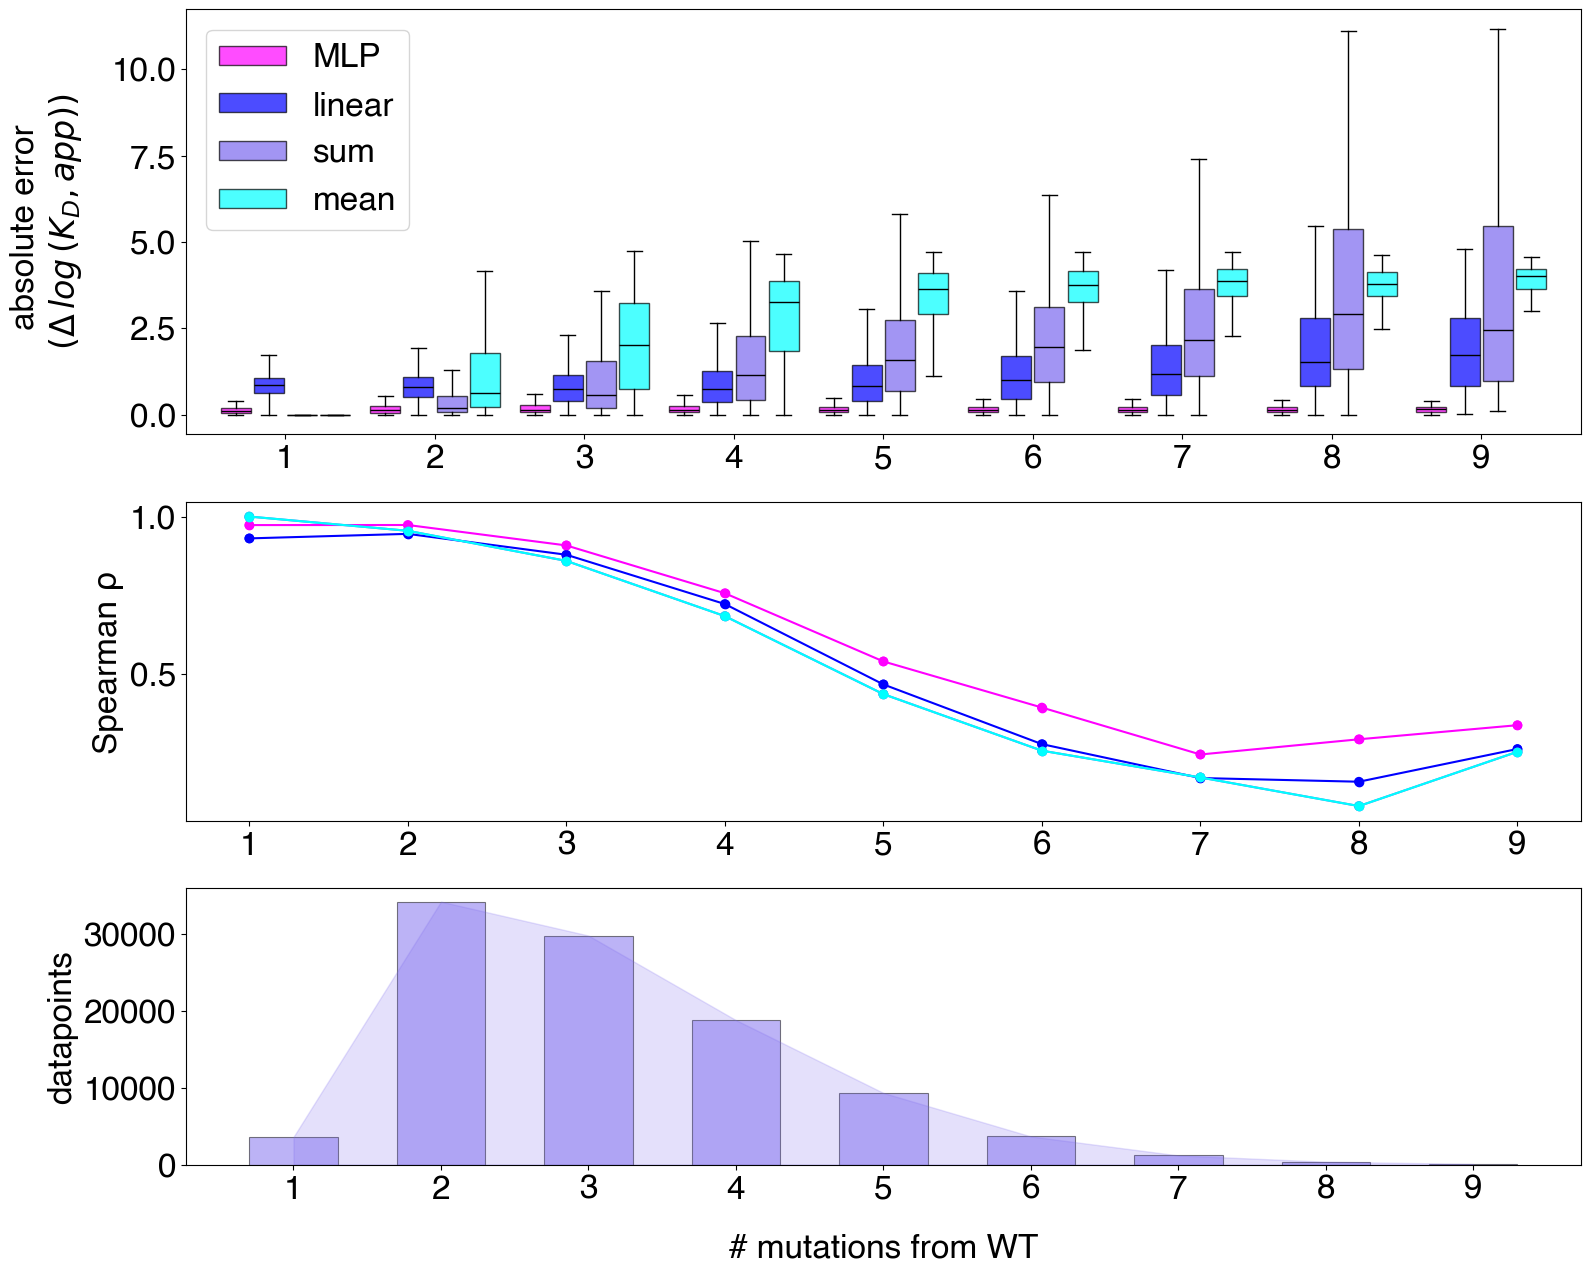

In [273]:
# Plot everything
### plot box & whisker of AE

fig, (AE_ax, ax2, ax3) = plt.subplots(3, 1, figsize=(18,15),
                               gridspec_kw={'height_ratios': [2,1.5,1.3]})

group_spacing = 1.5
n_violins = 4
spread = 1
position_offset = np.linspace(-spread/2, spread/2, n_violins)

methods = ['MLP', 'linear', 'sum', 'mean']
colors = ['fuchsia', 'blue', 'mediumslateblue', 'cyan'] * len(keys)

positions = []
box_data = []

for i, key in enumerate(keys):
    y = label_dict[key]

    for j, method in enumerate(methods):
        if method == 'MLP':
            x = pred_dict[key]
        elif method == 'linear':
            x = linear_dict[key]
        elif method == 'sum':
            x = additive_dict[key]
        elif method == 'mean':
            x = mean_dict[key]

        AEs = [abs(x - y) for x, y in zip(x, y)]
        box_data.append(AEs)
        positions.append(i * group_spacing + position_offset[j])

# Create plot
bplot = AE_ax.boxplot(box_data, positions=positions, widths=0.3, patch_artist=True, showfliers=False)

# Coloring
for patch, color in zip(bplot['boxes'], colors * len(keys)):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')

# Median lines
for median in bplot['medians']:
    median.set_color('black')
    median.set_linewidth(1)

# Legend
from matplotlib.patches import Patch
legend_patches = [Patch(facecolor=c, edgecolor='black', label=m, alpha=0.7)
                  for c, m in zip(colors, methods)]

AE_ax.legend(
    handles=legend_patches,
    loc='upper left',
    handlelength=2,
    handleheight=0.5,
    borderaxespad=0.6
)

### plot spearman rho

rho_values = [rho_dict[(key, method)] for key in keys for method in methods]
rho_keys = [key for key in keys for method in methods]

ax2.scatter(rho_keys, rho_values, color=colors) #, label=method)

for j, method in enumerate(methods):
    method_positions = list(keys)  # or sorted(keys) if not already
    method_rhos = [rho_dict[(key, method)] for key in method_positions]
    ax2.plot(method_positions, method_rhos, marker="o", color=colors[j], label=method)


### plot histogram of samples considered in calculation 
samples = []
for key in keys:
    samples.append(len(label_dict[key]))

ax3.bar(keys, samples, color="mediumslateblue", alpha=0.5, width=.6, edgecolor="black", linewidth=0.8)
ax3.fill_between(keys, samples, color="mediumslateblue", alpha=0.2)  # optional shading

# Set ticks and labels
AE_ax.set_xticks([i * group_spacing for i in range(len(keys))])
AE_ax.set_xticklabels(keys)  
AE_ax.set_ylabel('absolute error \n' r"$(\Delta\/ log\/(K_D,app))$", labelpad=20)

ax2.set_ylabel("Spearman ρ")
#ax2.set_xlabel("# mutations from WT", labelpad=20)

ax3.set_ylabel("datapoints")
ax3.set_xlabel("# mutations from WT", labelpad=20)
ax3.set_xticks(keys)
ax3.set_xticklabels(keys)

# ax2.set_xticks([i * group_spacing for i in range(len(keys))])
# ax2.set_xticklabels(keys) 
fig.savefig('{}/size_accuracy_breakdown.png'.format(directory), bbox_inches='tight')

plt.show()

# Sequence Logo Plots

In [311]:
def logo_plot(residues, datasets, kind, train_eval=False, figsize=(18, 6), graph_threshold=0.1, score_threshold=False, name=None, save=False):
    """

    Generate logo plot, only mutations from WT are shown

    Args:
        residues (list[int]): list of residues to include
        datasets (list[str]): list of paths to csvs containing sequences / scores according to format defined by 'kind'
        kind (str): options: 'simulation' or 'train' This is necessary because each source of data is formatted differently
        train_eval (bool, optional): True if train eval data will be used. This is wonky because train_eval format didn't output sequences,
                                   because they are the same as those in the train data. Therefore, the train data list must include 
                                   the path to train_eval, *first* and the path(s) to train data with sequences last. Default is False.
        figsize ((int,int), optional): matplotlib figure size, default (18,6)
        graph_threshold (float, optional): threshold above which the graph will be split into a second axis, default 0.1
        score_threshold (bool, optional): if True, only include sequences above a threshold, currently hard coded as >= 0, default False
        name (str, optional): filename (including path) for saving if 'save'=True 
        save (bool, optional): saves file to 'name' if True, default False
    
    """
    if save and name is None:
        raise ValueError("'name' must be provided if 'save' is True")
        
    sequences = []    

    if kind == 'simulation':
        for data in datasets:
            df = pd.read_csv(data)
            seqs = df.iloc[:, :-2].astype(str).apply(lambda row: ''.join(row), axis=1).tolist()
            
            if score_threshold:
                scores = df["energy"].tolist()
                for seq, score in zip(seqs, scores):
                    if score >= 0:
                        sequences.append(seq)
            else:
                sequences.extend(seqs)

    elif kind == 'train':

        if train_eval:
            train_eval_df = pd.read_csv(datasets[0])
            scores = train_eval_df.iloc[:, 2].tolist()

            for data in datasets[1:]:
                df = pd.read_csv(data)
                seqs = df.iloc[:, 1].tolist()

                if score_threshold:
                    for seq, score in zip(seqs, scores):
                        if score >= 0:
                            sequences.append(seq)
                else: 
                    sequences.extend(seqs)
        else:
            for i,data in enumerate(datasets):
                df = pd.read_csv(data)
                seqs = df.iloc[:, 1].tolist()
                scores = df.iloc[:, 2].tolist()

                if score_threshold:
                    for seq, score in zip(seqs, scores):
                        if i == 0:
                            if score >= 0:
                                sequences.append(seq)
                        else:
                            if score >= -.9:
                                sequences.append(seq)
                else: 
                    sequences.extend(seqs)

    print(len(sequences))
    # elif kind == 'genbank':
    #     genbank_seqs = genbank_df.iloc[:, 1].tolist()
    #     for seq in genbank_seqs:
    #         if len(seq) == 201:  
    #             sequences.append(seq)

                            
    if not sequences:
        raise ValueError("No sequences found to plot.")
        
    matrix = logomaker.alignment_to_matrix(sequences, to_type='probability')
    
    # replace wt values with 0 to show only mutations
    for i in range(201):
        matrix.loc[i, wt_seq[i]] = 0
    
    filtered_matrix = matrix.loc[[p - 331 for p in residues]]
    filtered_matrix.index = residues  # keep residue positions as index
    
    # --- Split matrix based on max value in each row ---
    max_vals = filtered_matrix.max(axis=1)
    low_matrix = filtered_matrix[max_vals <= graph_threshold]
    high_matrix = filtered_matrix[max_vals > graph_threshold]
    
    # --- Color scheme ---
    cmap = matplotlib.colormaps['cool']
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(amino_acidsl) - 1)
    aa_color_dict = {
        aa: matplotlib.colors.to_hex(cmap(norm(i)))
        for i, aa in enumerate(amino_acidsl)
    }
    
    # --- Prepare dataframes for plotting ---
    def prep_logo_df(df):
        df_plot = df.reset_index(drop=True)  # logomaker needs numeric index for x
        tick_labels = df.index.to_list()     # store actual residue positions
        return df_plot, tick_labels
    
    low_df, low_ticks = prep_logo_df(low_matrix)
    high_df, high_ticks = prep_logo_df(high_matrix)
    
    # --- Plot ---
    fig, (ax1, ax2) = plt.subplots(
        1, 2,
        figsize=figsize,
        gridspec_kw={'width_ratios': [max(1, len(low_df)), max(1.5, len(high_df))]}
    )
    
    # --- Left plot: Low probs ---
    if not low_df.empty:
        logomaker.Logo(low_df, ax=ax1, color_scheme=aa_color_dict, font_name='Helvetica')
        ax1.set_xticks(range(len(low_ticks)))
        ax1.set_xticklabels(low_ticks, rotation=45)
        ax1.set_ylabel("probability", labelpad=20)
    else:
        ax1.axis("off")
        
    # --- Right plot: High probs ---
    if not high_df.empty:
        logomaker.Logo(high_df, ax=ax2, color_scheme=aa_color_dict, font_name='Helvetica')
        ax2.set_xticks(range(len(high_ticks)))
        ax2.set_xticklabels(high_ticks, rotation=45)        
    else:
        ax2.axis("off")
        
    fig.text(.5,-.06,'residue', ha='center', fontsize=24)
    plt.tight_layout()

    if save:
        fig.savefig('{}.png'.format(name), bbox_inches='tight')
    plt.show()

40926


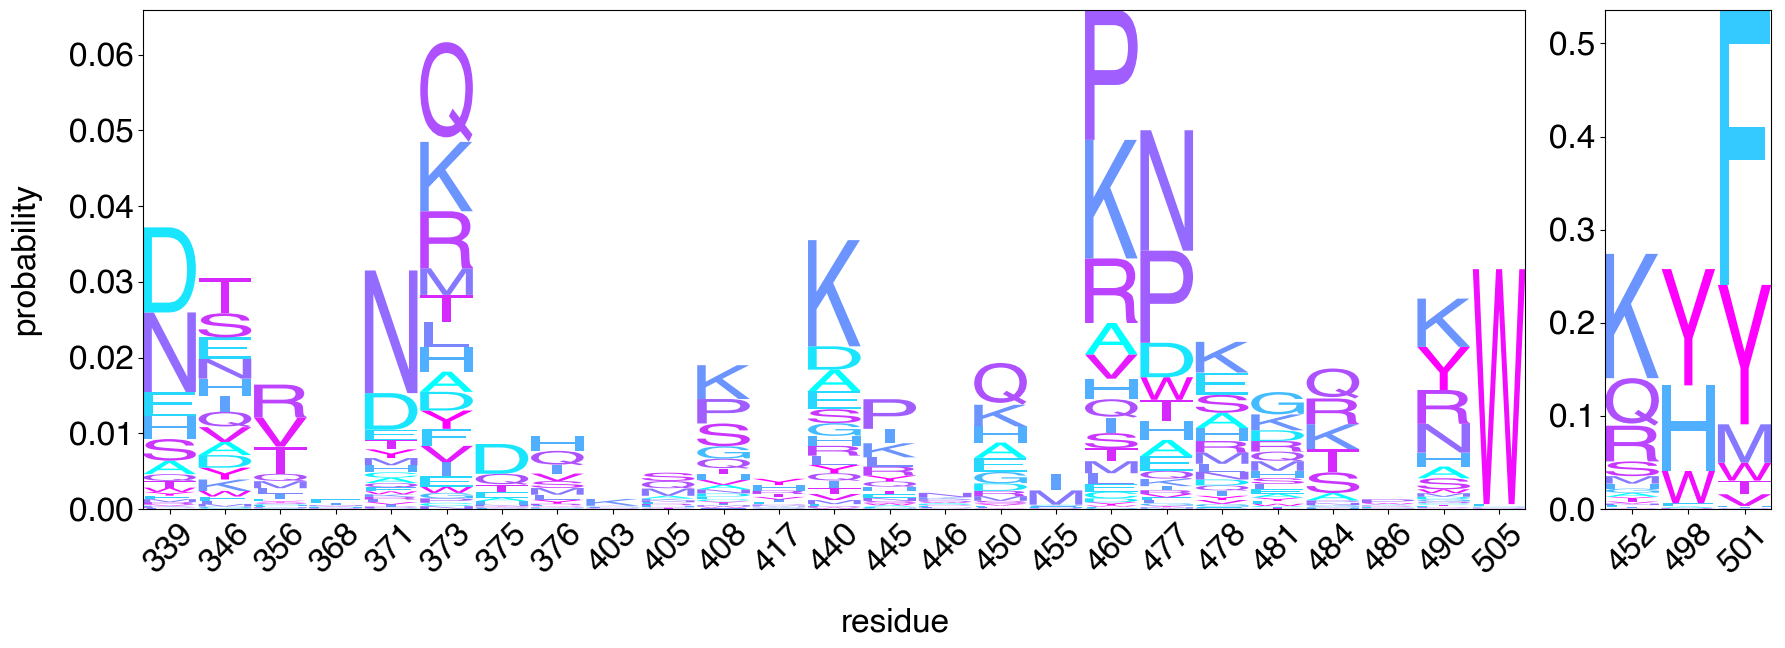

In [308]:
# simulation 
residues = [339,346,356,368,371,373,375,376,403,405,408,417,440,445,446,450,452,455,460,477,478,481,484,486,490,498,501,505]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/sim_tables_1/TESTEVAL_mlp_l[16, 32, 16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt_sim_table.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/sim_base_logo"
logo_plot(residues, datasets, kind="simulation", train_eval=False, figsize=(18, 6), graph_threshold=0.1, score_threshold=False, name=None, save=False)

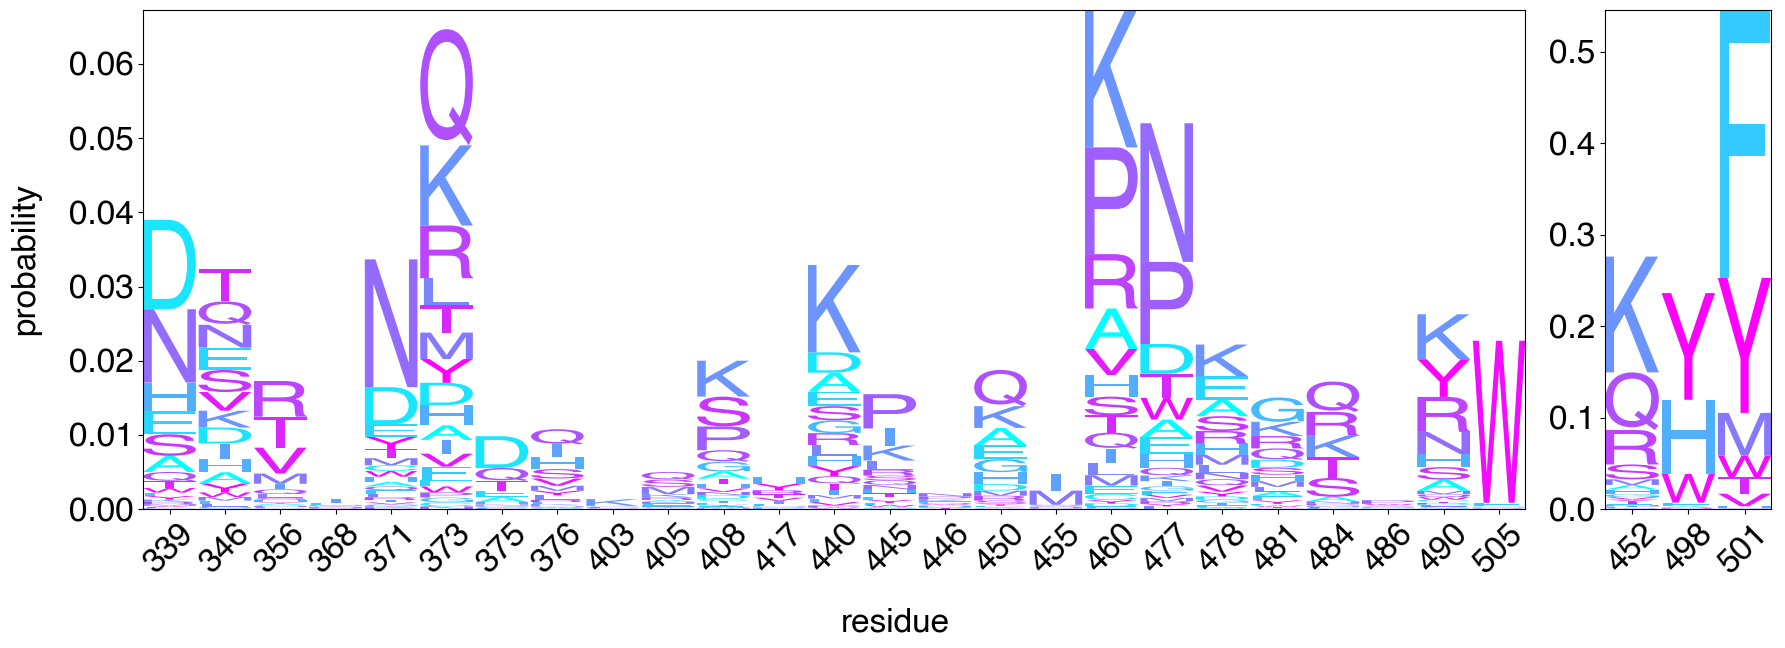

In [147]:
# simulation 
residues = [339,346,356,368,371,373,375,376,403,405,408,417,440,445,446,450,452,455,460,477,478,481,484,486,490,498,501,505]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/sim_tables_2/TESTEVAL_mlp_l[16, 32, 16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt_sim_table.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/sim_base_logo2"
logo_plot(residues, datasets, kind="simulation", train_eval=False, figsize=(18, 6), graph_threshold=0.1, score_threshold=False, name=name, save=True)

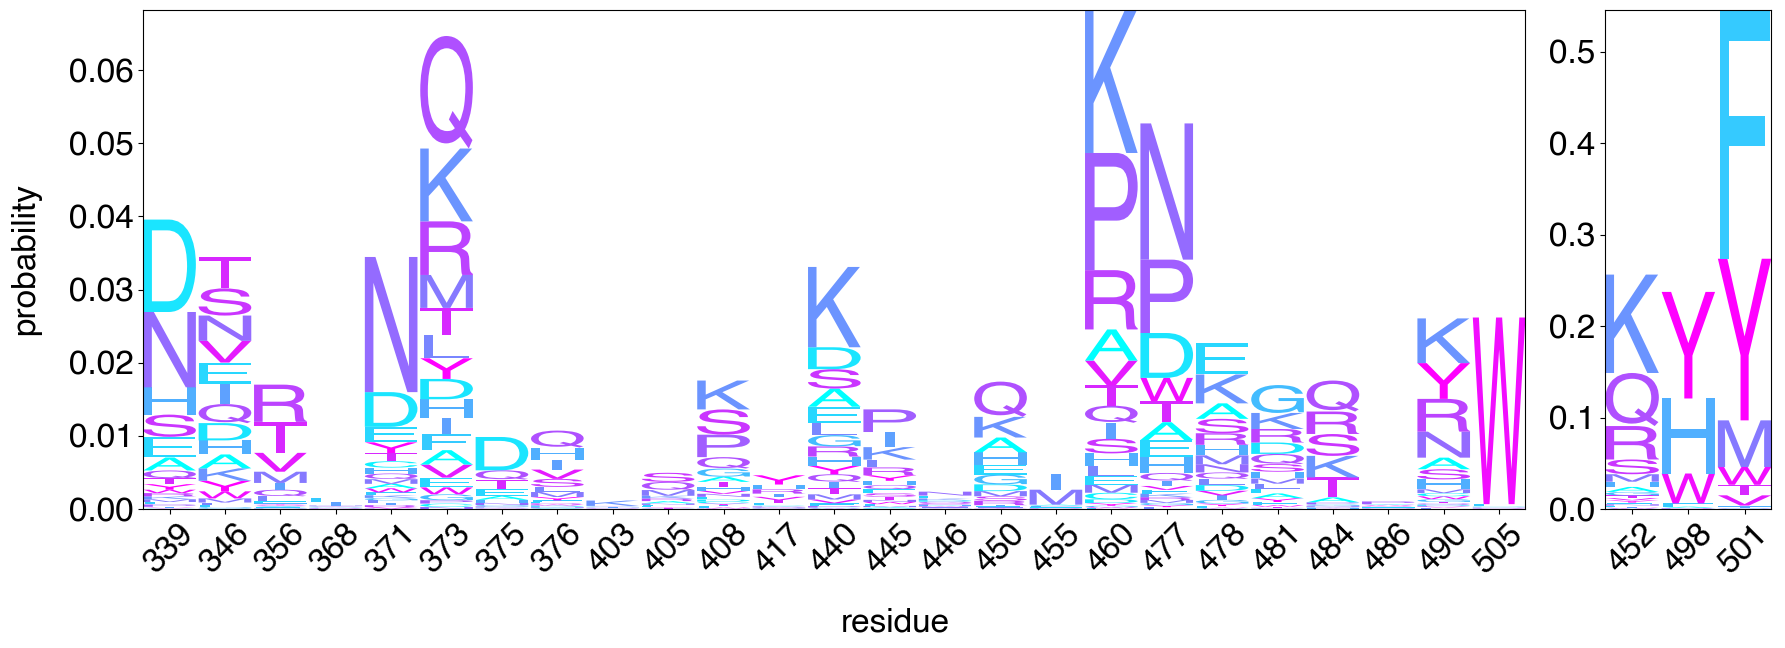

In [148]:
# simulation 
residues = [339,346,356,368,371,373,375,376,403,405,408,417,440,445,446,450,452,455,460,477,478,481,484,486,490,498,501,505]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/sim_tables_3/TESTEVAL_mlp_l[16, 32, 16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt_sim_table.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/sim_base_logo3"
logo_plot(residues, datasets, kind="simulation", train_eval=False, figsize=(18, 6), graph_threshold=0.1, score_threshold=False, name=name, save=True)

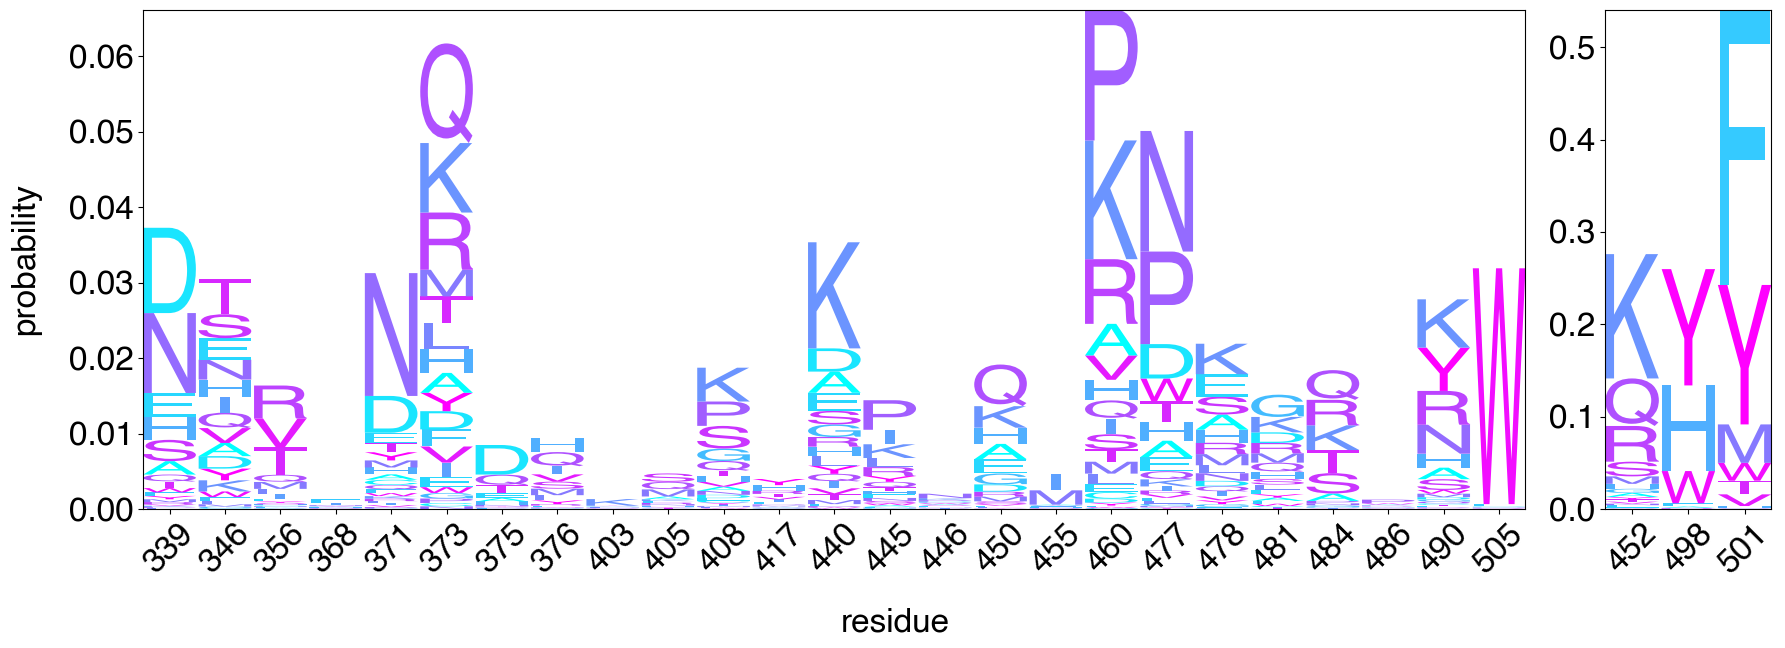

In [180]:
# simulation with threshold 
residues = [339,346,356,368,371,373,375,376,403,405,408,417,440,445,446,450,452,455,460,477,478,481,484,486,490,498,501,505]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/sim_tables_1/TESTEVAL_mlp_l[16, 32, 16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt_sim_table.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/sim_threshold_base_logo"
logo_plot(residues, datasets, kind="simulation", train_eval=False, figsize=(18, 6), graph_threshold=0.1, score_threshold=True, name=None, save=False)

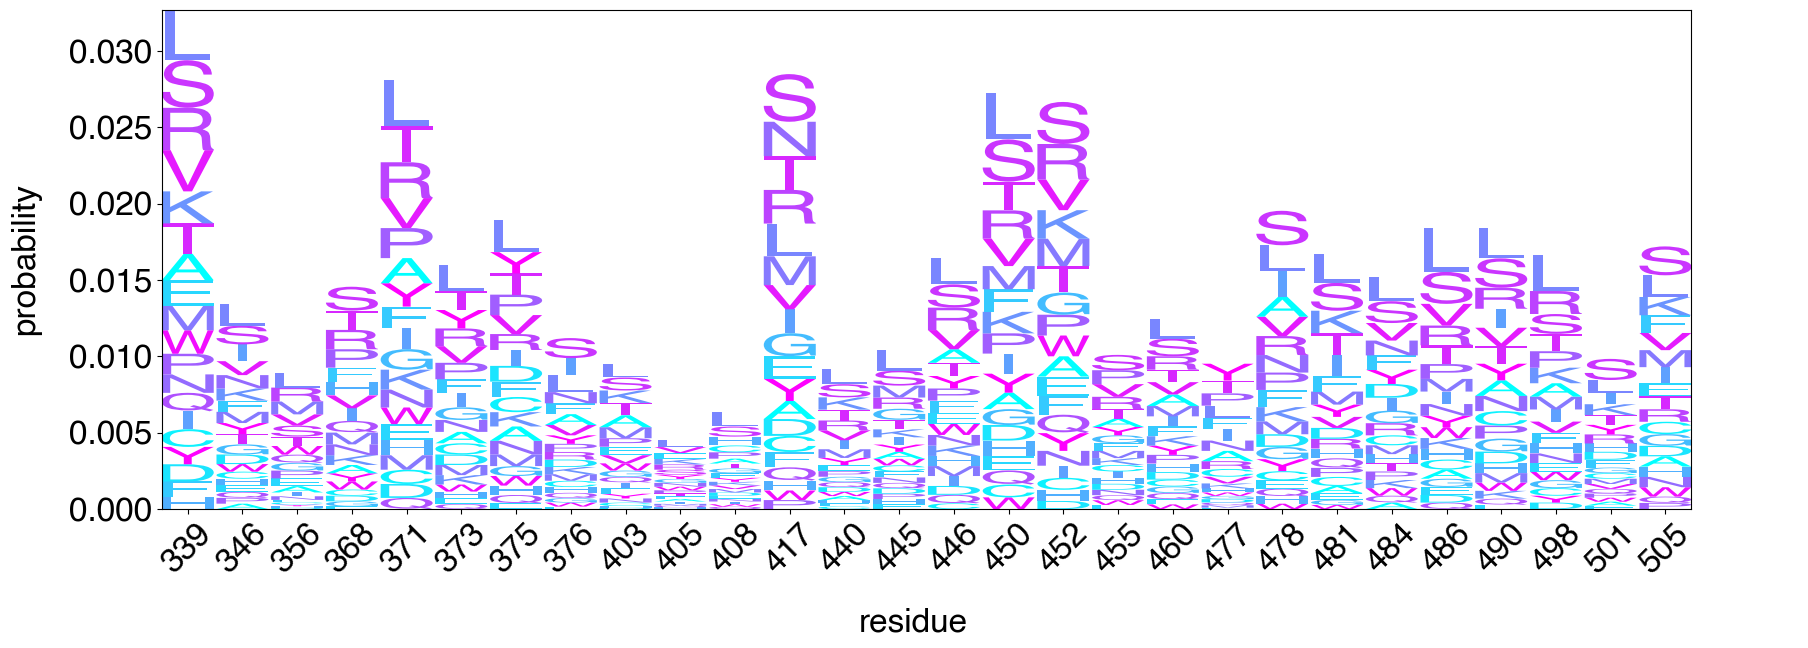

In [184]:
# training data no threshold
residues = [339,346,356,368,371,373,375,376,403,405,408,417,440,445,446,450,452,455,460,477,478,481,484,486,490,498,501,505]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/train_data.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/train_base_logo"
logo_plot(residues, datasets, kind="train", train_eval=False, figsize=(18, 6), graph_threshold=0.1, score_threshold=False, name=name, save=True)

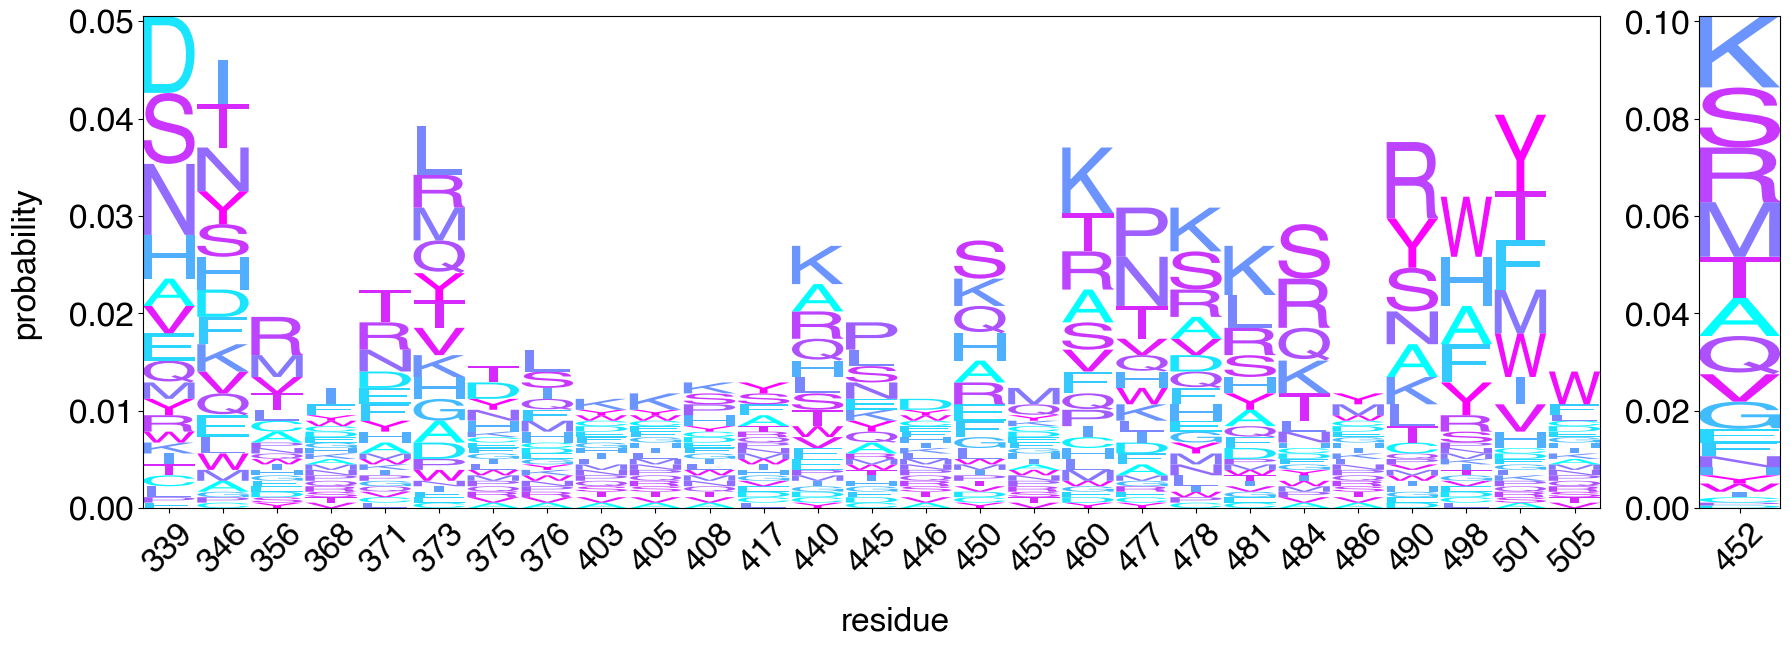

In [202]:
# training data with threshold
residues = [339,346,356,368,371,373,375,376,403,405,408,417,440,445,446,450,452,455,460,477,478,481,484,486,490,498,501,505]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/train_data.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/train_threshold_base_logo"
logo_plot(residues, datasets, kind="train", train_eval=False, figsize=(18, 6), graph_threshold=0.01, score_threshold=True, name=name, save=True)

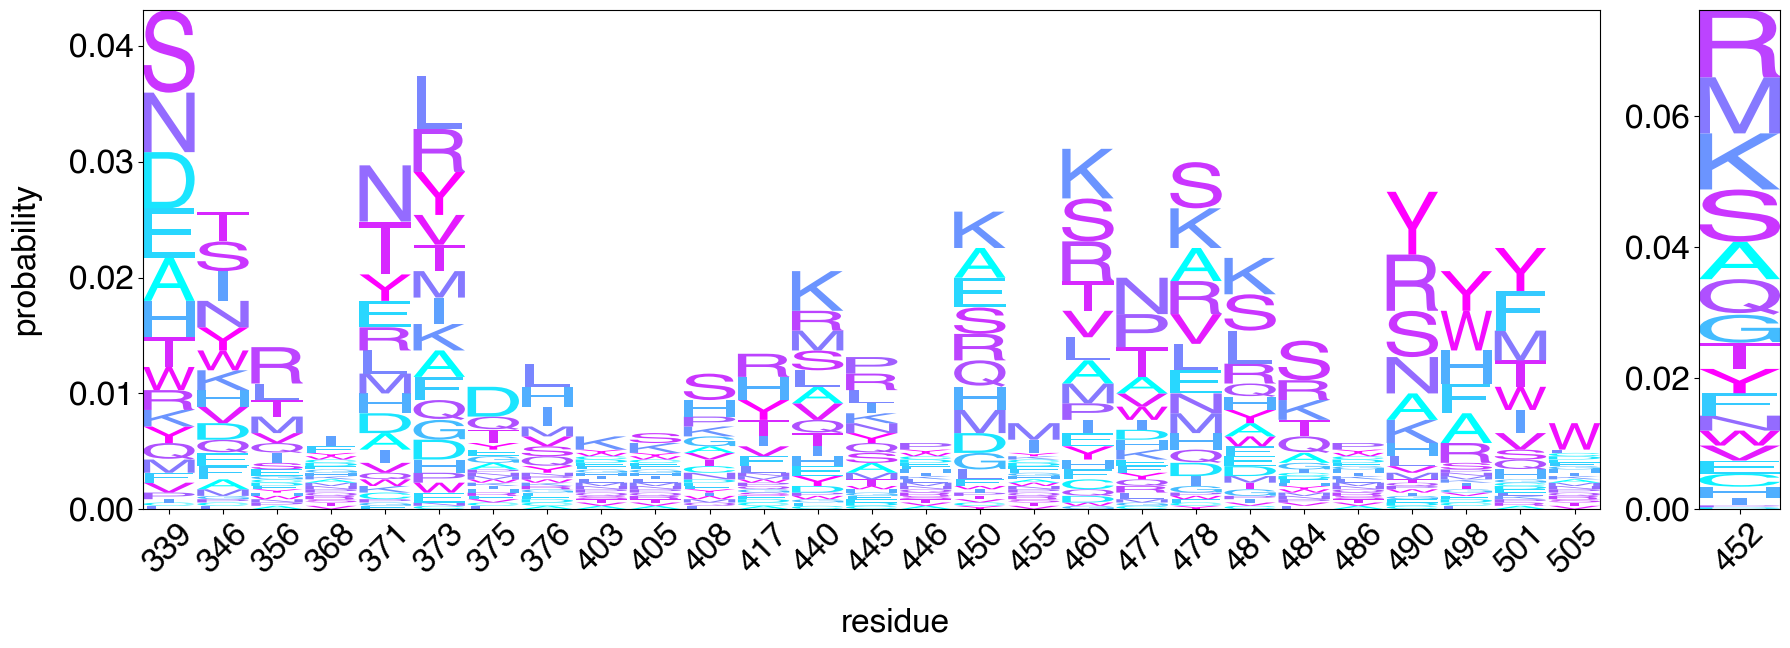

In [212]:
# denoised training data with threshold (base data)
residues = [339,346,356,368,371,373,375,376,403,405,408,417,440,445,446,450,452,455,460,477,478,481,484,486,490,498,501,505]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/train_eval/TRAINEVAL_mlp_l[16,32,16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt_train_pred_table.csv","/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/train_data.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/train_denoised_threshold_base_logo"
logo_plot(residues, datasets, kind="train", train_eval=True, figsize=(18, 6), graph_threshold=0.01, score_threshold=True, name=name, save=True)

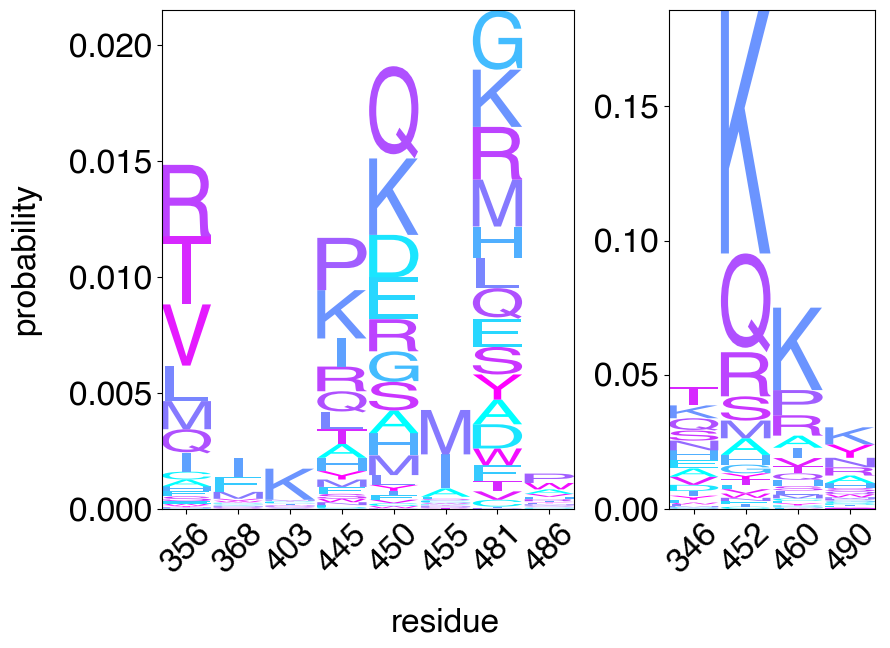

In [234]:
# simulation (all data)
residues = [346,356,368,403,445,450,452,455,460,481,486,490]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/sim_tables_1/TESTEVAL_mlp_l[8, 8, 8]_wdecay0.0005_learningrate0.0001_alldata_fan8_multiattempt_sim_table.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/sim_all_logo"
logo_plot(residues, datasets, kind="simulation", train_eval=False, figsize=(9, 6), graph_threshold=0.005, score_threshold=False, name=name, save=True)

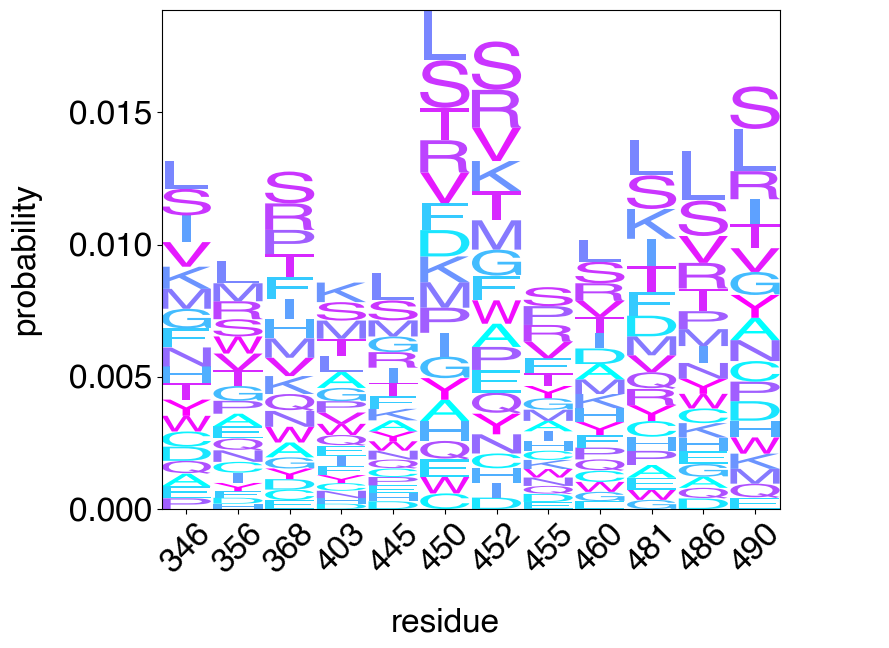

In [227]:
# training data without threshold (all data)
residues = [346,356,368,403,445,450,452,455,460,481,486,490]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/train_data.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_B1351.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_E484K.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_N501Y.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_BA1.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_BA2.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_Wuhan_Hu_1.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_Wuhan_Hu_1.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/train_all_no_threshold_logo"
logo_plot(residues, datasets, kind="train", train_eval=False, figsize=(9, 6), graph_threshold=0.03, score_threshold=False, name=name, save=True)

1782


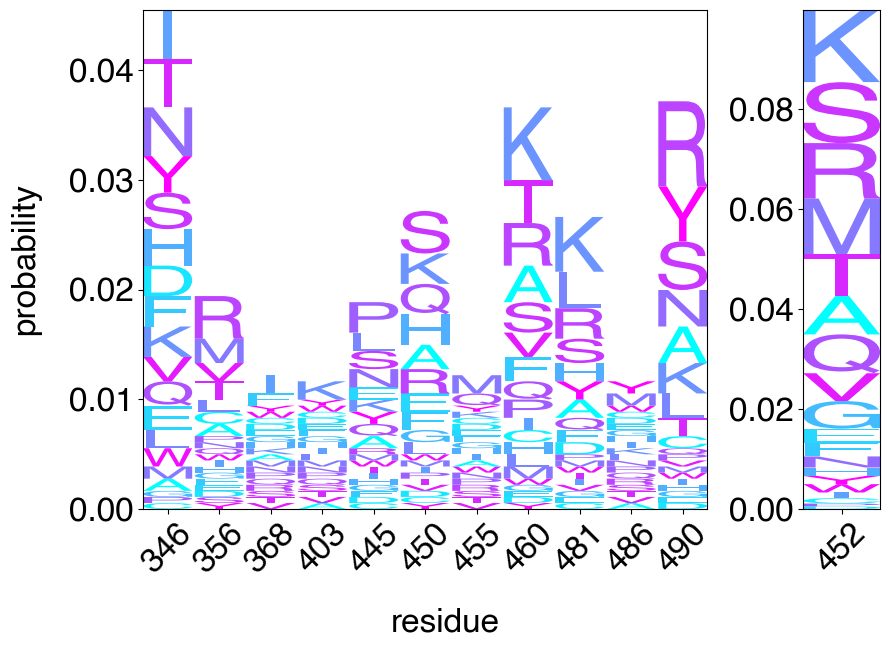

In [294]:
# training data with threshold (all data)
residues = [346,356,368,403,445,450,452,455,460,481,486,490]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/train_data.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_B1351.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_E484K.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_N501Y.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_BA1.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_BA2.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_Wuhan_Hu_1.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_Wuhan_Hu_1.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/train_all_threshold_logo"
logo_plot(residues, datasets, kind="train", train_eval=False, figsize=(9, 6), graph_threshold=0.01, score_threshold=True, name=name, save=True)

2579


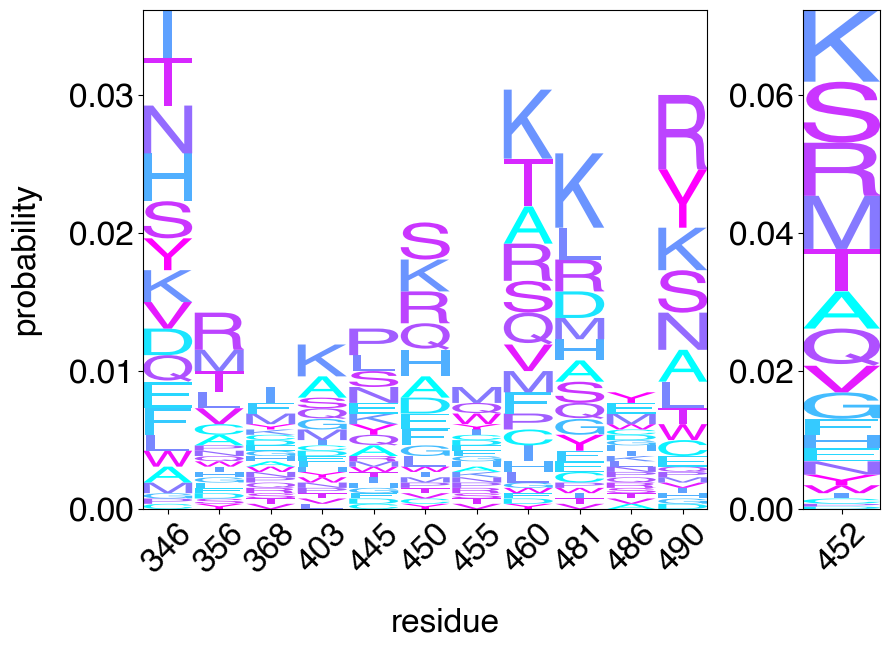

In [312]:
# training threshold all data thresh = -.9 (manually edited this in function to give other sets their own threshold)
residues = [346,356,368,403,445,450,452,455,460,481,486,490]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/train_data.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_B1351.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_E484K.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_N501Y.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_BA1.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_BA2.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_Wuhan_Hu_1.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_Wuhan_Hu_1.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/train_all_threshold-.9_logo"
logo_plot(residues, datasets, kind="train", train_eval=False, figsize=(9, 6), graph_threshold=0.01, score_threshold=True, name=name, save=True)

13441


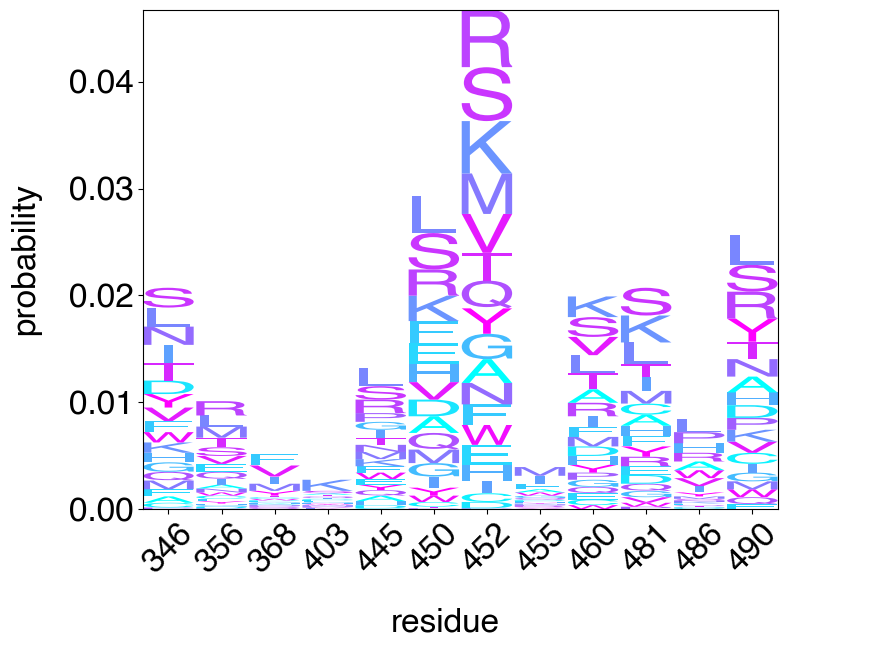

In [301]:
# training threshold all data thresh = -0.5
residues = [346,356,368,403,445,450,452,455,460,481,486,490]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/train_data.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_B1351.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_E484K.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_N501Y.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_BA1.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_BA2.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_Wuhan_Hu_1.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_Wuhan_Hu_1.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/train_all_threshold-0.5_logo"
logo_plot(residues, datasets, kind="train", train_eval=False, figsize=(9, 6), graph_threshold=0.01, score_threshold=True, name=name, save=True)

368


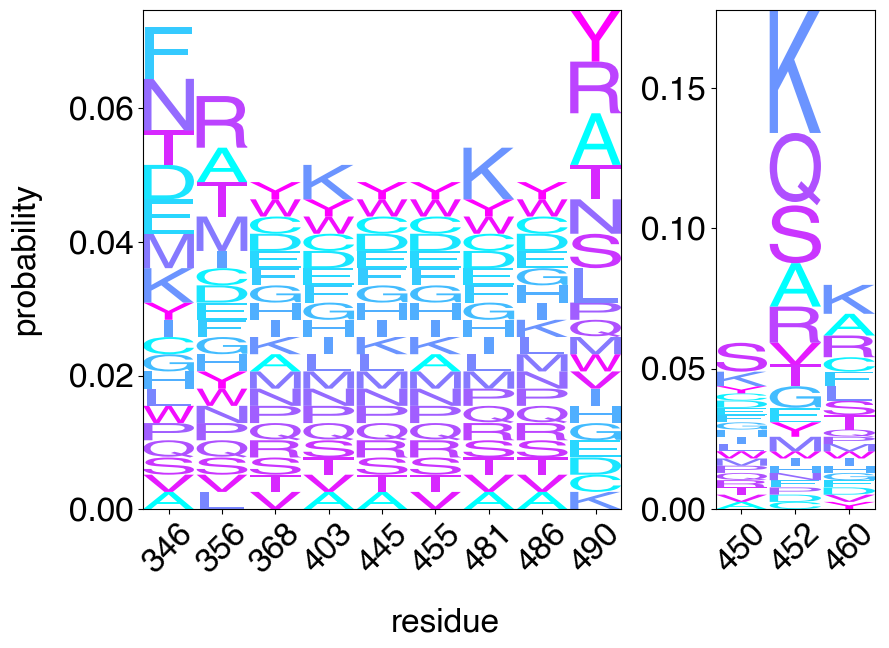

In [299]:
# training threshold all data thresh = 0.1
residues = [346,356,368,403,445,450,452,455,460,481,486,490]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/train_data.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_B1351.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_E484K.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_N501Y.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_BA1.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_BA2.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_Wuhan_Hu_1.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_Wuhan_Hu_1.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/train_all_threshold0.1_logo"
logo_plot(residues, datasets, kind="train", train_eval=False, figsize=(9, 6), graph_threshold=0.01, score_threshold=True, name=name, save=True)

1372


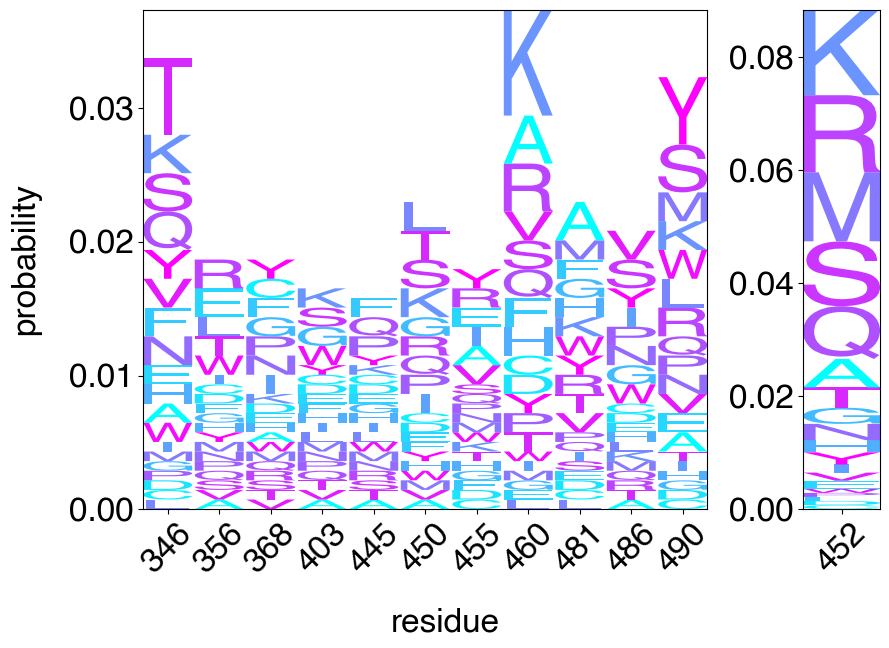

In [303]:
# denoised training data with threshold (all data)
residues = [346,356,368,403,445,450,452,455,460,481,486,490]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/train_eval/TRAINEVAL_mlp_l[8,8,8]_wdecay0.0005_learningrate0.0001_alldata_fan8_multiattempt_train_pred_table.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/train_data.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_B1351.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_E484K.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_N501Y.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_BA1.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_BA2.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_omicron_Wuhan_Hu_1.csv",
            "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/other_datasets/not_norm_train_data_Wuhan_Hu_1.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/denoised_train_all_threshold_logo"
logo_plot(residues, datasets, kind="train", train_eval=True, figsize=(9, 6), graph_threshold=0.01, score_threshold=True, name=name, save=True)

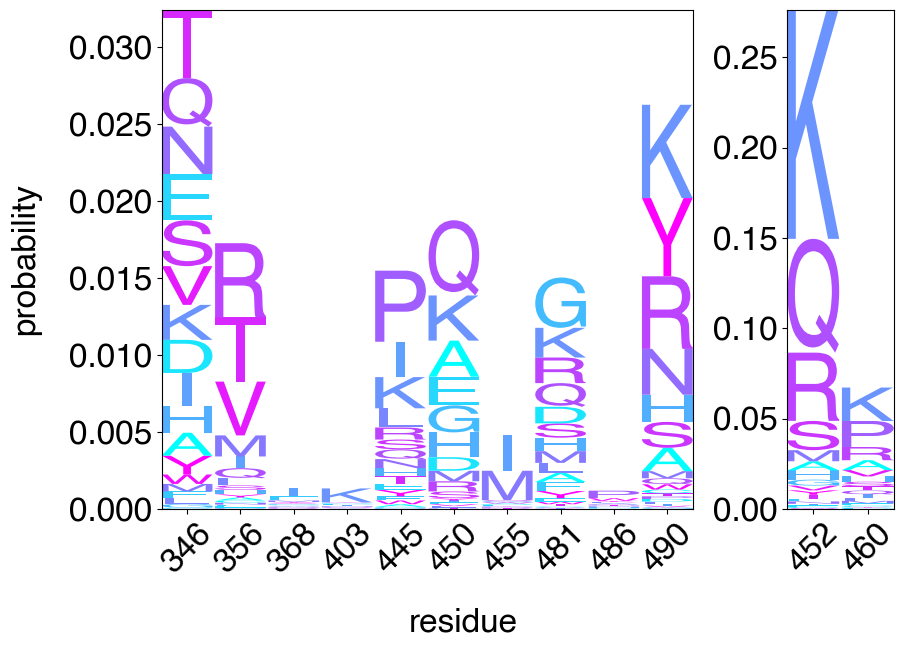

In [286]:
# simulation base after BA.2 residues
# simulation 
residues = [346,356,368,403,445,450,452,455,460,481,486,490]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/sim_tables_2/TESTEVAL_mlp_l[16, 32, 16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt_sim_table.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/sim_base_afterBA2_logo"
logo_plot(residues, datasets, kind="simulation", train_eval=False, figsize=(9, 6), graph_threshold=0.01, score_threshold=False, name=name, save=True)

1762


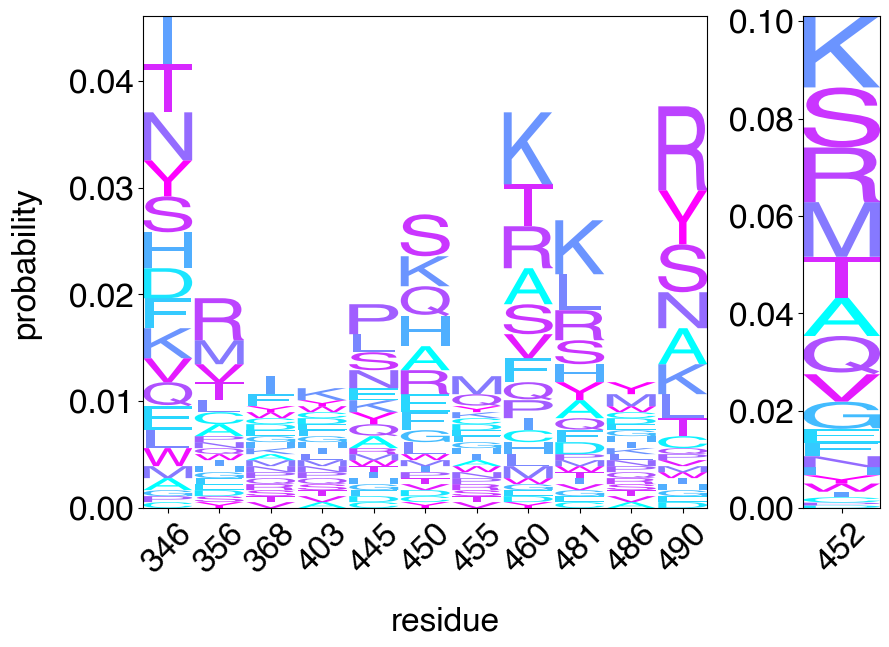

In [295]:
# training base after BA.2
residues = [346,356,368,403,445,450,452,455,460,481,486,490]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/train_data.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/train_threshold_base_afterBA2_logo"
logo_plot(residues, datasets, kind="train", train_eval=False, figsize=(9, 6), graph_threshold=0.01, score_threshold=True, name=name, save=True)

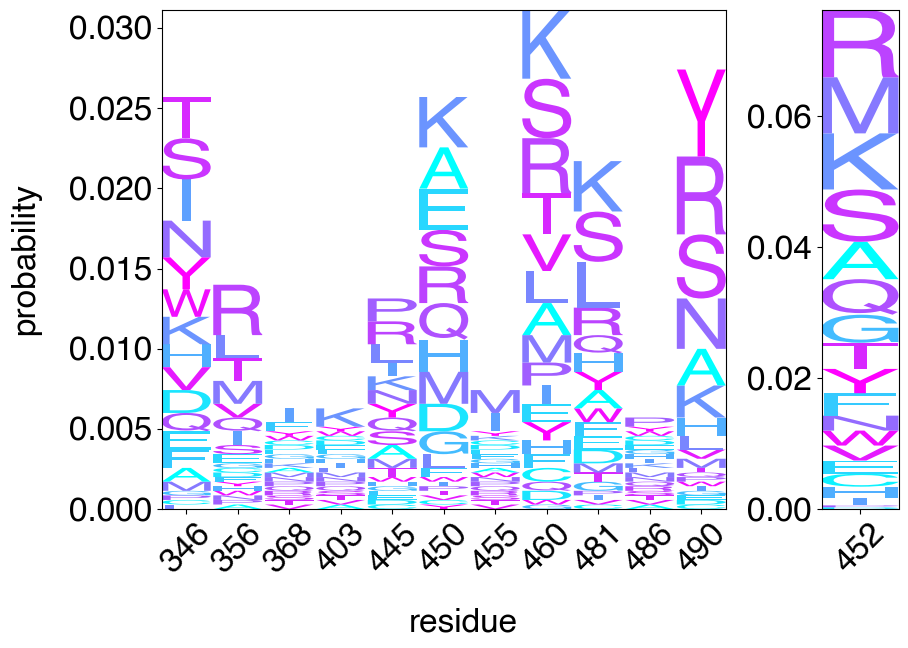

In [290]:
# denoised training base after BA.2
residues = [346,356,368,403,445,450,452,455,460,481,486,490]
datasets = ["/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/train_eval/TRAINEVAL_mlp_l[16,32,16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt_train_pred_table.csv","/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/raw/train_data.csv"]
name = "/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/results/train_denoised_threshold_base_afterBA2_logo"
logo_plot(residues, datasets, kind="train", train_eval=True, figsize=(9, 6), graph_threshold=0.01, score_threshold=True, name=name, save=True)

# UMAP sequence space 

In [131]:
def onehot_flat_embed(sequences):
    amino_acids = np.asarray(list("ACDEFGHIKLMNPQRSTVWY"), dtype='<U1')
    onehot_flat_l = []

    for seq in sequences:
        arr = np.zeros((len(seq), len(amino_acids)), dtype=np.float32)
        for i, aa in enumerate(seq):
            if aa in amino_acids:
                arr[i, amino_acids == aa] = 1.0
        onehot_flat_l.append(arr.flatten())
    return onehot_flat_l

In [132]:
def apply_mutations(wt_seq, mutations):
    wt_list = list(wt_seq)
    for mut in mutations:
        orig = mut[0]
        pos = int(mut[1:-1])
        new = mut[-1]

        i = pos - 331  # Adjust for 0-based indexing
        if wt_list[i] != orig:
            raise ValueError(f"Expected {orig} at position {pos}, but found {wt_list[i]}")
        
        if new != orig:
            wt_list[i] = new
        else:
            raise ValueError(f"New residue is same as the original")
            
    return ''.join(wt_list)

In [133]:
strain2mut = {'alpha': ['E484K','N501Y'],
'beta': ['K417N', 'E484K', 'N501Y'],
'gamma': ['K417T', 'E484K', 'N501Y'],
'delta': ['L452R', 'T478K'],
'epsilon': ['L452R'],
'eta_iota_zeta': ['E484K'], 
'iota_prime': ['S477N'],
'kappa': ['L452R', 'E484Q'],  
'mu': ['R346K', 'E484K', 'N501Y'], 
'omicron_BA1': ['G339D', 'S371L', 'S373P', 'S375F', 'K417N', 'N440K', 
                'G446S', 'S477N', 'T478K', 'E484A', 'Q493R', 'G496S',
                'Q498R', 'N501Y', 'Y505H'],
'omicron_BA2': ['G339D', 'S371L', 'S373P', 'S375F', 'T376A', 'D405N',
                'R408S', 'K417N', 'N440K', 'S477N', 'T478K', 'E484A',
                'Q493R', 'Q498R', 'N501Y', 'Y505H'],
'BA45' : ["G339D", "S371F", "S373P", "S375F", "T376A", "D405N", "R408S",
          "K417N", "N440K", "L452R", "S477N", "T478K", "E484A", "F486V", 
          "Q498R", "N501Y", "Y505H"],
'XBB15' : ["G339H", "R346T", "L368I", "S371F", "S373P", "S375F", "T376A",
              "D405N", "R408S", "K417N", "N440K", "V445P", "G446S", "N460K", 
              "S477N", "T478K", "E484A", "F486P", "F490S",  "Q498R",
              "N501Y", "Y505H"], # "R493Q" reversion to WT
'JN1' : ["G339H", "K356T", "S371F", "S373P", "S375F", "T376A", "R403K", 
         "D405N", "R408S", "K417N", "N440K", "V445H", "G446S", "N450D", 
         "L452W", "L455S", "N460K", "S477N", "T478K", "N481K", "V483-", 
         "E484K", "F486P", "Q498R", "N501Y", "Y505H"]}

In [281]:
def plot_umap(directory, sim_data, train_data, name=None, c=100, n=150, m=.1, max_mut=False, annotate=True, save=False, threshold=True, add_train=False):

    """ 
    Plot UMAP to compare sequence space of Genbank, simulation, and training data. 
    
    Args:
        directory (str): path to data
        sim_data (str): name of simulation csv 
        train_data (str): name of training data csv
        name (str or None): name of file to save to, if save=True 
        c (int, optional): components for PCA reduction, default is 100
        n (int, optional): umap n_neighbors, default is 150
        m (float, optional): umap min_dist, default is .1
        max_mut (bool, optional): set a maximum number of <= 10 mutations in the genbank sequences plotted, default is False
        annotate (bool, optional): label the strains on the first graph, default is True, when False black dots will still be plotted on first graph for labeling in illustrator
        save (bool, optional): save to folder in directory under mcmc/results/ default is False, if true name variable must be set.
        threshold (bool, optional): give a score threshold >=0 to training data, default is True
        add_train (bool, optional): fit training data above threshold to the umap embedding calculated with the threshold and add grey points to training graph
    
    """
    # initiate list of scores and sequences for all groups
    
    if save and name is None:
        raise ValueError("'name' must be provided if 'save' is True")
        
    scores = []
    seqs = [wt_seq]

    strains = ['wt']
    strains.extend(strain2mut.keys())
    for strain in strain2mut:
        seqs.append(apply_mutations(wt_seq, strain2mut[strain])) # mannually add VOC group for labeling
    scores.extend([0] * len(strains))
    assert len(strains) == len(scores)
    print('VOCs: '+str(len(strains)))

    genbank_seqs = []
    genbank_df = pd.read_csv('{}/raw/genbank_rbd_strain_mutations.csv'.format(directory))
    genbank_sequences = genbank_df.iloc[:, 1].tolist()
    
    for seq in genbank_sequences:
        if len(seq) == 201: # Only keep sequences with correct length
            if max_mut:
                if sum(c1 != c2 for c1, c2 in zip(seq, wt_seq)) <= 10:
                    genbank_seqs.append(seq)
            else:
                genbank_seqs.append(seq)
                
    scores.extend([0] * len(genbank_seqs))
    
    seqs.extend(genbank_seqs)
    assert len(seqs) == len(scores)
    print('genbank: '+str(len(genbank_seqs)))
            
    sim_seqs = [] # length needed for indexing 
    for data in sim_data:
        sim_df = pd.read_csv('{}{}'.format(directory, data))
        sim_sequences = sim_df.iloc[:, :-2].astype(str).apply(lambda row: ''.join(row), axis=1).tolist()
        sim_scores = sim_df['energy']

        # if threshold:
        #     for i,score in enumerate(sim_scores):
        #         if score >= 0:
        #             sim_seqs.append(sim_sequences[i])
        #             scores.append(score)

        # else:
        sim_seqs.extend(sim_sequences)
        scores.extend(sim_scores)
    seqs.extend(sim_seqs)
    assert len(seqs) == len(scores)
    print('simulation: '+str(len(sim_seqs)))   

    train_seqs = []
    over_seqs = []
    for data in train_data:
        train_df = pd.read_csv('{}{}'.format(directory, data))
        train_sequences = train_df.iloc[:, 1].tolist()
        train_scores = train_df.iloc[:, 2].tolist()

        if threshold:
            for i,score in enumerate(train_scores):
                if score >= 0:
                    train_seqs.append(train_sequences[i])
                    scores.append(score)
                else:
                    over_seqs.append(train_sequences[i])

        else:
            train_seqs.extend(train_sequences)
            scores.extend(train_scores)
    seqs.extend(train_seqs)
    assert len(seqs) == len(scores)
    print('train: '+str(len(train_seqs)))

    print('total: '+str(len(seqs)))
    print('train below threshold: '+str(len(over_seqs)))
    
    seq_groups = [strains, genbank_seqs, sim_seqs, train_seqs]
    group_lengths = [len(g) for g in seq_groups]
    
    cumulative_lengths = np.cumsum([0] + group_lengths)
    
    onehot = onehot_flat_embed(seqs)
    onehot_over = onehot_flat_embed(over_seqs)
    
    ### UMAP 
                
    pca = PCA(n_components=c)    
    umap = UMAP(n_components=2, n_neighbors=n, min_dist=m)
    onehot_pca = pca.fit_transform(onehot)
    onehot_umap_fit = umap.fit(onehot_pca)
    onehot_umap = onehot_umap_fit.transform(onehot_pca)

    onehot_over_pca = pca.fit_transform(onehot_over)
    over_seqs_umap = onehot_umap_fit.transform(onehot_over_pca)

    ### Graph
    fig, axes = plt.subplots(1, 3, figsize=(19, 5), sharex=True, sharey=True)
    
    # Get indices for the VOC (to overlay)
    ref_start, ref_end = cumulative_lengths[0], cumulative_lengths[1]
    ref_indices = np.arange(ref_start, ref_end)
    
    labels = ['variants of concern', 'Genbank', 'simulation', 'training']
    
    # Create a normalization object (shared across all scatters)
    norm = matplotlib.colors.Normalize(vmin=0, vmax=max(scores))
    
    # Loop over last 3 groups
    for plot_idx, group_idx in enumerate([1, 2, 3]):
        ax = axes[plot_idx]
    
        # Get indices for this group
        start, end = cumulative_lengths[group_idx], cumulative_lengths[group_idx + 1]
        indices = np.arange(start, min(end, onehot_umap.shape[0]))
        
        # Plot current group, colored by score
        group_scores = np.array(scores)[indices]
        x = onehot_umap[indices, 0]
        y = onehot_umap[indices, 1]
        
        # Define colormap and normalization
        cmap = plt.cm.cool
        
        # Initialize color array (RGBA)
        colors = np.zeros((len(group_scores), 4))  # shape (N, 4)
        
        # Get grey RGBA value
        grey_rgba = matplotlib.colors.to_rgba('grey')
        
        # Assign colors
        mask = group_scores >= 0
        colors[~mask] = grey_rgba
        colors[mask] = cmap(norm(group_scores[mask]))
        
        # Plot
        ax.scatter(x, y, c=colors, s=10)
                
        #ax.scatter(onehot_umap[indices, 0], onehot_umap[indices, 1], c=group_scores, cmap='cool', norm=norm, s=10)
    
        ax.set_title(labels[group_idx])
    
        if plot_idx == 0:    
            ax.scatter(onehot_umap[ref_indices, 0], onehot_umap[ref_indices, 1],
                   color='black', s=10, label=labels[0])

            if annotate:
                for i, txt in enumerate(strains):
                    ax.annotate(txt, (onehot_umap[i,0], onehot_umap[i,1]), fontsize=12)

        if add_train:  
            if plot_idx == 2:
                ax.scatter(over_seqs_umap[indices, 0], over_seqs_umap[indices, 1], c='grey', s=10)
    
    # Add a single shared colorbar with same norm
    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='cool'),
                        ax=axes, fraction=0.046, pad=0.04)
    cbar.set_label(r"$(\Delta\/ log\/(K_D,app))$", labelpad=20)
        
    if save:
        fig.savefig('{}/mcmc/results/{}.png'.format(directory,name), bbox_inches='tight')
    plt.show()

VOCs: 15
genbank: 27965
simulation: 40581
train: 1762
total: 70323


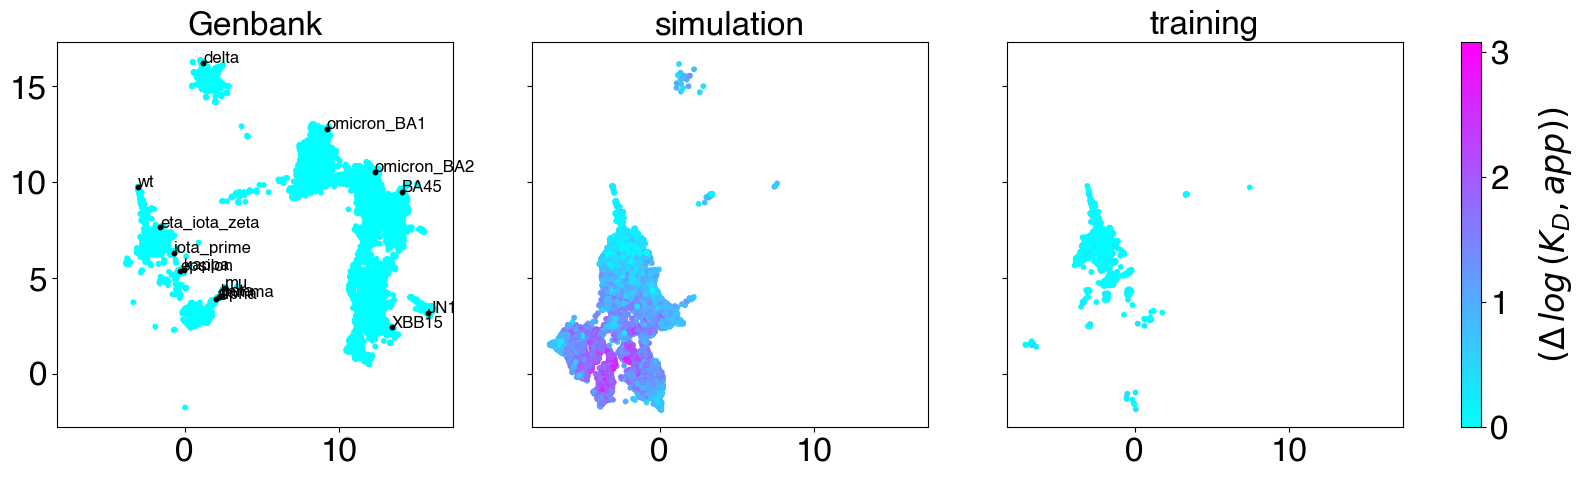

In [179]:
# UMAPs annotated first, thresholded
directory = '/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/'
sim_data = ['mcmc/sim_tables_1/TESTEVAL_mlp_l[16, 32, 16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt_sim_table.csv']
train_data = ['raw/train_data.csv']
name = 'base'
plot_umap(directory, sim_data, train_data, name, c=100, n=150, m=.1, annotate=True, save=False, threshold=True)

VOCs: 15
genbank: 27965
simulation: 40581
train: 1762
total: 70323


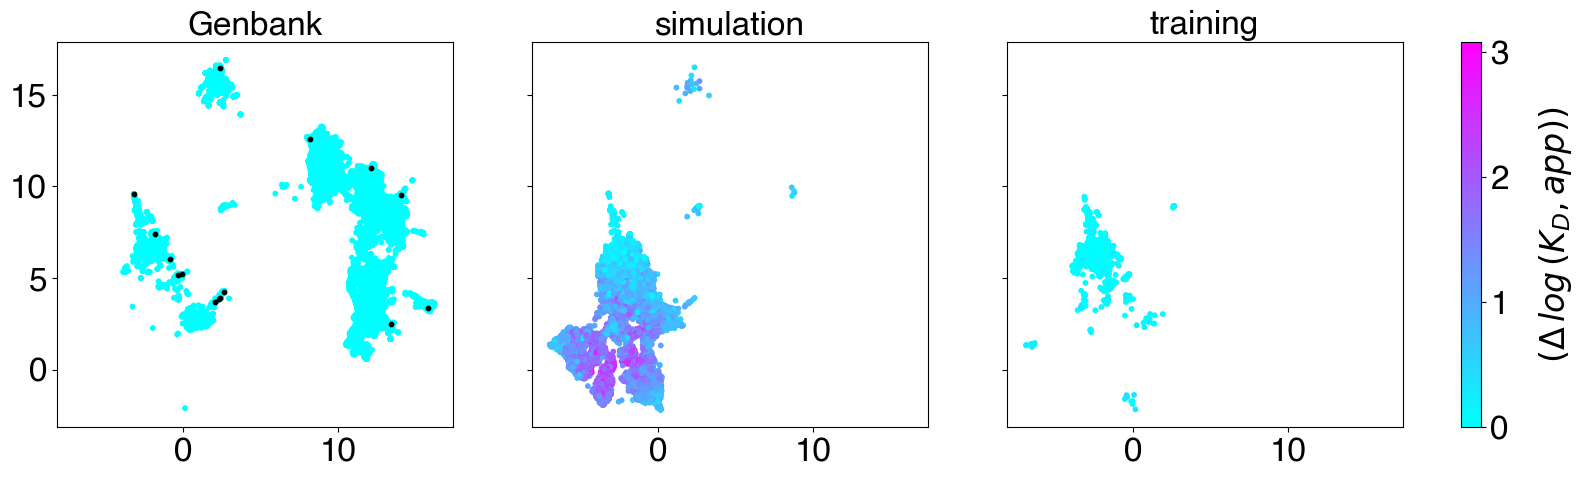

In [173]:
#UMAP threshold
directory = '/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/'
sim_data = ['mcmc/sim_tables_1/TESTEVAL_mlp_l[16, 32, 16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt_sim_table.csv']
train_data = ['raw/train_data.csv']
name = 'base'
plot_umap(directory, sim_data, train_data, name, c=100, n=150, m=.1, annotate=False, save=True, threshold=True)

VOCs: 15
genbank: 27965
simulation: 40926
train: 1762
total: 70668
train below threshold82657


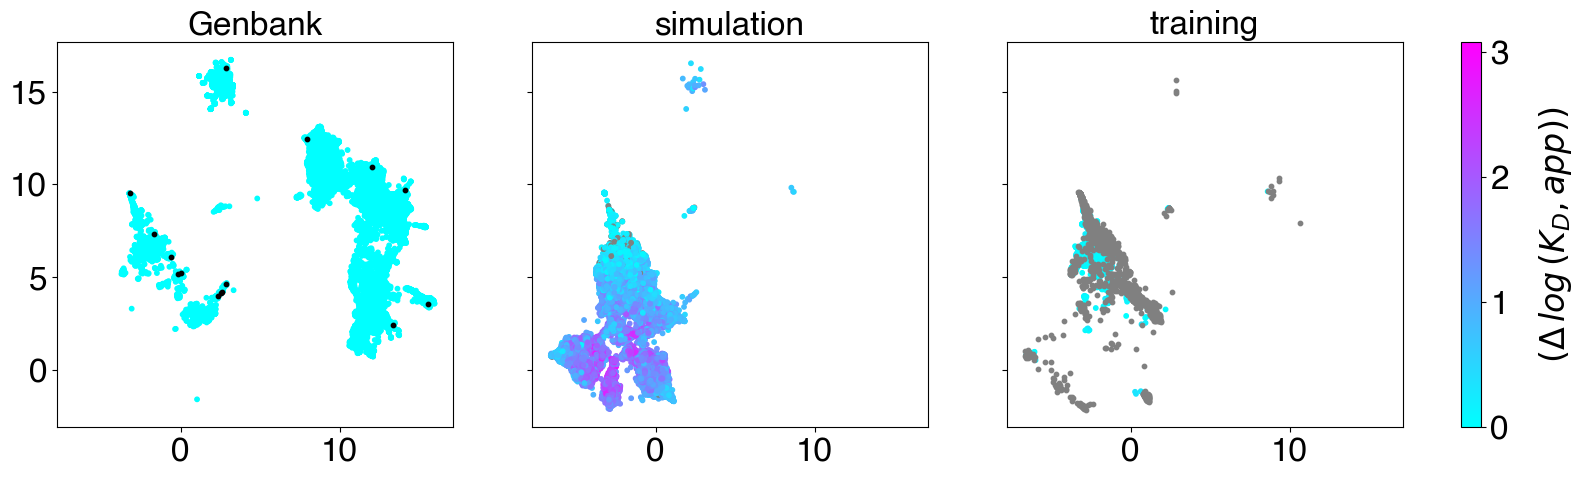

In [280]:
directory = '/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/'
sim_data = ['mcmc/sim_tables_1/TESTEVAL_mlp_l[16, 32, 16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt_sim_table.csv']
train_data = ['raw/train_data.csv']
name = 'base_add_train'
plot_umap(directory, sim_data, train_data, name, c=100, n=150, m=.1, annotate=False, save=True, threshold=True, add_train=True)

VOCs: 15
genbank: 27965
simulation: 40926
train: 84419
total: 153325


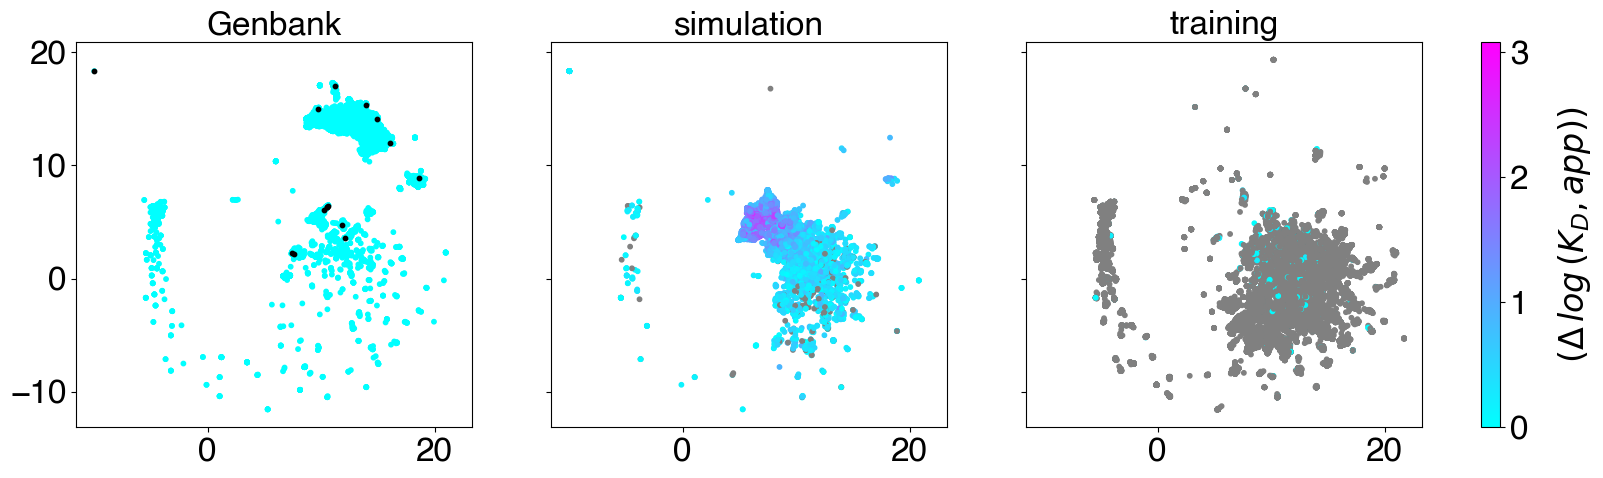

In [177]:
## Cant find clusters if all training data used. We believe this is due to the fact that it does not follow a fitness distribution
directory = '/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/'
sim_data = ['mcmc/sim_tables_1/TESTEVAL_mlp_l[16, 32, 16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt_sim_table.csv']
train_data = ['raw/train_data.csv']
name = 'UMAP_no_thresh'
plot_umap(directory, sim_data, train_data, name, c=100, n=150, m=.1, annotate=False, save=True, threshold=False)

# Simulation mutation and delta log KD distribution 

nb


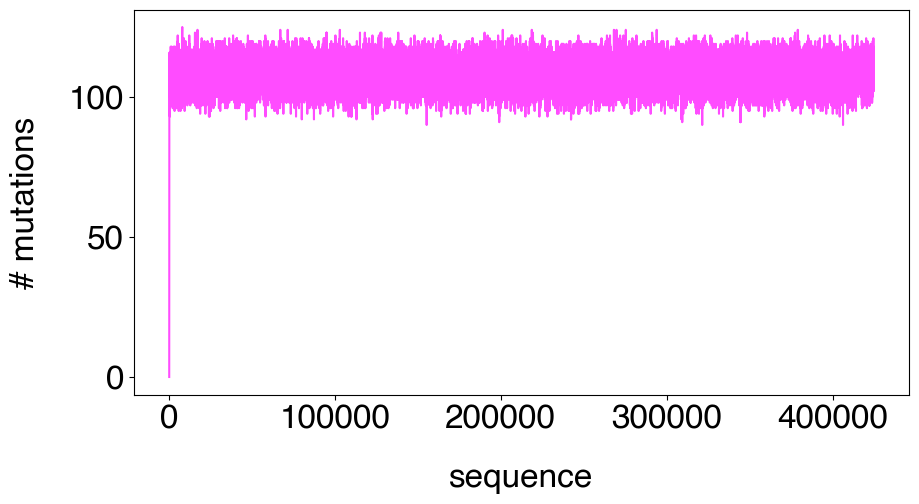

unlimited


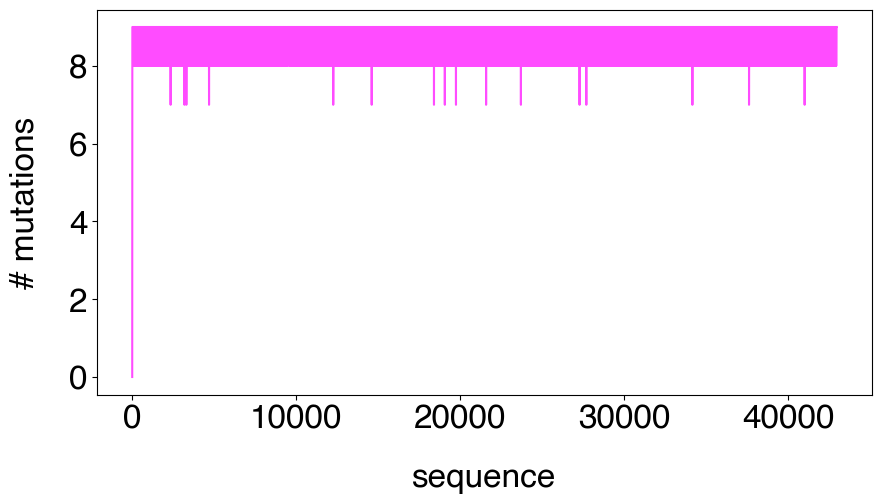

biased


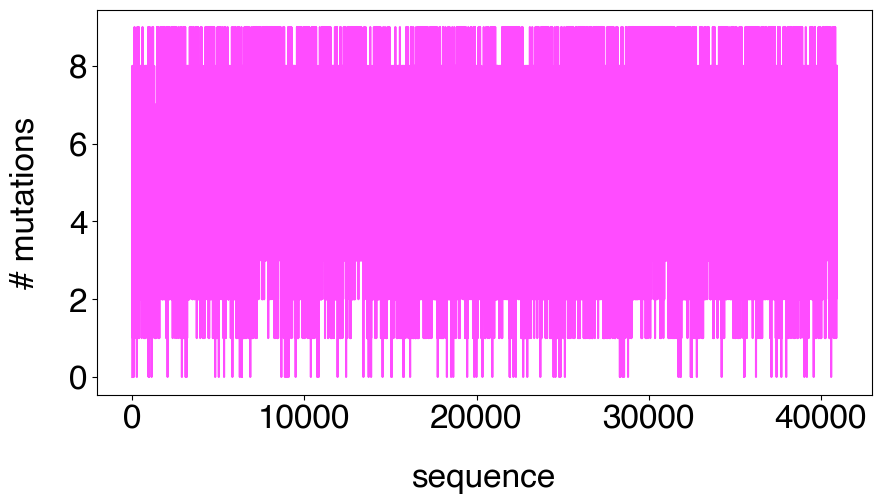

In [318]:
# line graphs for mutation count
datasets = ["unlimited/sim_tables_1/TESTEVAL_mlp_l[8, 8, 8]_wdecay0.0005_learningrate0.0001_alldata_fan8_multiattemptunlimited_sim_table.csv",
            "unlimited/sim_tables_1/TESTEVAL_mlp_l[8, 8, 8]_wdecay0.0005_learningrate0.0001_alldata_fan8_multiattemptno_nb_sim_table.csv",           
            "sim_tables_1/TESTEVAL_mlp_l[16, 32, 16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt_sim_table.csv"]

directory = '/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/'

names = ['nb','unlimited','biased']
for i,data in enumerate(datasets):
        df = pd.read_csv('{}{}'.format(directory,data))
        sequences = df.iloc[:, :-2].astype(str).apply(lambda row: ''.join(row), axis=1).tolist()
        step = df.iloc[:, -2].tolist()
        y = df.iloc[:, -1].tolist()

        wt_mut = []
        for seq in sequences:
            wt_mut.append(sum(c1 != c2 for c1, c2 in zip(seq, wt_seq)))

        print(names[i])

        fig = plt.figure(figsize=(10,5))
        ax1 = fig.add_subplot(1,1,1)
        ax1.plot(np.array(wt_mut), color="fuchsia", alpha=.7)
        ax1.set_ylabel("# mutations",labelpad=20)
        ax1.set_xlabel("sequence", labelpad=20)
        
        plt.show()
        fig.savefig('{}results/{}_sim_mut_graph.png'.format(directory,names[i]), bbox_inches='tight')

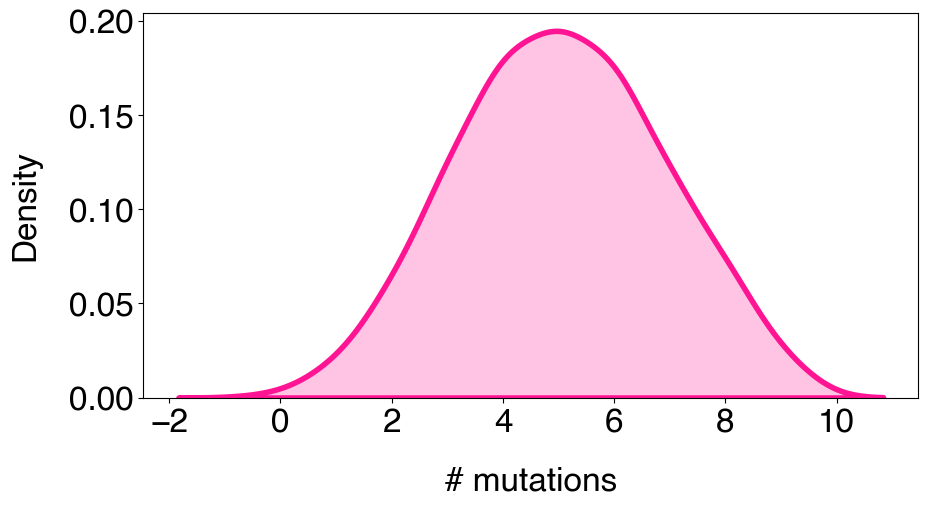

In [331]:
directory = '/Users/tsztain/Library/Mobile Documents/com~apple~CloudDocs/UMich/publications/DMS/mcmc/'
data = 'TESTEVAL_mlp_l[16, 32, 16]_wdecay0.0001_learningrate0.0001_baseonly_nulltuner_multiattempt_sim_table.csv'

df = pd.read_csv('{}sim_tables_1/{}'.format(directory,data))
sequences = df.iloc[:, :-2].astype(str).apply(lambda row: ''.join(row), axis=1).tolist()
y = df.iloc[:, -1].tolist()

wt_mut = []
for seq in sequences:
    wt_mut.append(sum(c1 != c2 for c1, c2 in zip(seq, wt_seq)))

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,1,1)

sns.kdeplot(wt_mut, bw_adjust=2.8, ax=ax1, color='deeppink', linewidth=4,fill=True)

ax1.set_ylabel('Density', labelpad=20)
ax1.set_xlabel('# mutations', labelpad=20)

fig.savefig('{}/results/base_only_mutation_hist.png'.format(directory), bbox_inches='tight')
plt.show()

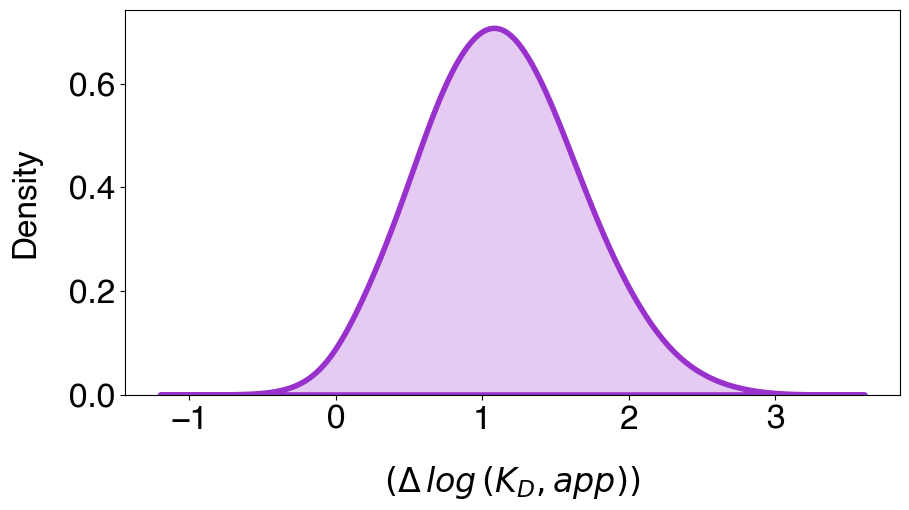

In [332]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,1,1)

sns.kdeplot(y, bw_adjust=2.8, ax=ax1, color='darkorchid', linewidth=4,fill=True)

ax1.set_ylabel('Density', labelpad=20)
ax1.set_xlabel(r"$(\Delta\/ log\/(K_D,app))$", labelpad=20)

fig.savefig('{}/results/base_only_ddg_hist.png'.format(directory), bbox_inches='tight')
plt.show()